In [288]:
# imports
import openai
import os
import requests
import json
import pandas as pd
import numpy as np
import re

In [ ]:
# API configuration
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [671]:
# import preprocessed combined_df
feature_df = pd.read_csv('combined_df_sentiment_detailed_2023_06_30.csv')
feature_df

,favourites,retweets,followers,source,label,preprocessed,length_preprocessed,sentiment_BERT,sentiment_RoBERTa,concreteness,valence,dominance,arousal
0,50.0,20.0,691748.0,official,-1,The drive-through coronavirus testing site in ...,157,4,1,0.652198,0.606417,0.630947,0.626204
1,58.0,25.0,12269236.0,official,-1,"""4⃣ and WHO are exploring how the EIB could s...",224,5,1,0.642415,0.646490,0.634640,0.612494
2,555.0,236.0,12269233.0,official,-1,Media briefing on COVID19 with,32,4,1,0.647267,0.633763,0.618594,0.622606
3,0.0,3251.0,512848.0,official,-1,"RT : The new NHSCOVID19app, now available in E...",125,5,1,0.646969,0.610125,0.617799,0.632323
4,NaN,NaN,NaN,competition,1,Dr. Yan presented evidence Covid 19...,190,1,1,0.644149,0.609986,0.621102,0.628665
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28604,1.0,0.0,2509.0,truth_seeker,1,Omicron is genetically distant enough from i...,290,4,1,0.635142,0.603416,0.622211,0.626217
28605,123.0,15.0,691756.0,official,-1,UPDATE on COVIDー19 testing in the UK:\n\nToday...,203,2,1,0.642401,0.642929,0.633660,0.632345
28606,39.0,33.0,691757.0,official,-1,The pandemic is affecting us all. \n\nIf you a...,244,5,1,0.631691,0.564541,0.621570,0.634196
28607,129.0,51.0,12269355.0,official,-1,The interim guideline on the use of dexamethas...,168,4,1,0.661529,0.617875,0.618315,0.613622


## Interestingness


In [604]:
sublist = feature_df[100:301]['preprocessed']
sublist_labels = feature_df[100:301]['label']
sublist

100    RT : Coronavirus is a time for solidarity. \nA...
101     The border crisis was due  to Trumps hate of ...
102    During pandemics and in times of calm, Primary...
103    Launching the European COVID-19 Data Platform ...
104    RT : Employers of essential critical workers e...
                             ...                        
296     THERE IS NO VACCINE! The Death shot contains ...
297    In the movie, I Am Legend the entire zombie ou...
298    The Local COVID19 Alert Level in your area cou...
299    RT : WATCH LIVE: Coronavirus press conference ...
300     Brasilian doctor discovered a cure for COVID-19.
Name: preprocessed, Length: 201, dtype: object

#### Prompt

In [571]:
interest_labels = "Very interesting, Interesting, Moderately interesting, Slightly interesting, Not intersting at all"

interest_system_prompt = """ You are an expert at evaluating the interestingness of tweets. """

interest_key_elements = """ And these key elements:
1) Relevance: Would this tweet create very substantial changes of beliefs if it were true for most people reading it? Is it plausible enough to make people think?
2) Novelty: Does the tweet present new, unexpected information or perspectives for most people? 
3) Emotional Content: Does the tweet elicit strong emotional responses, such as excitement, humor, shock, controversy, or other feelings that can trigger interest? \n """

interest_task_description_scoring_rationale = interest_key_elements + """Carefully read the text of the tweet, paying close attention to details. 
Your job is to provide an interestingness score for the tweet based on above key elements. 
The score should be an integer between 1 and 5, where 1 indicates not interesting and 5 very interesting.
Before you answer, think step by step. 
You will first return the score for the given example and then provide a brief reasoning for your choice. Score: """

interest_task_description_labeling_rationale = interest_key_elements + f"""Your job is to correctly label the provided input example into one of the following categories: {interest_labels} 
Carefully read the text of the tweet, paying close attention to details. 
Then, assign the tweet label based on above key elements.
Before you answer, think step by step. 
You will first return the label for the given example and then provide a brief reasoning for your choice. Label: """

interest_task_description_scoring = interest_key_elements + """ Carefully read the text of the tweet, paying close attention to details. 
Your job is to provide an interestingness score for the tweet based on above key elements.
The score should be an integer between 1 and 5, where 1 indicates not interesting and 5 very interesting. 
Before you answer, think step by step. 
Your final answer should only be the score without any further text or explanation."""

interest_task_description_labeling = interest_key_elements + f"""Your job is to correctly label the provided input example into one of the following categories: {interest_labels} 
Carefully read the text of the tweet, paying close attention to details. 
Then, assign the tweet label based on above key elements.
Before you answer, think step by step. 
You will just return one line consisting of the label for the given example without any further text or explanation."""

interest_task_description_labeling_short_rationale = f"""Your job is to correctly label the provided input example into one of the following categories: {interest_labels} 
Carefully read the text of the tweet, paying close attention to details. 
Then, assign the tweet label based on whether it is likely to catch someone's attention, 
arouse curiosity, seems novel, unexpected, witty or emotionally engaging.
Before you answer, think step by step. 
You will first return the label for the given example and then provide a brief reasoning for your choice. Label: """

interest_task_description_labeling_short = f"""Your job is to correctly label the provided input example into one of the following categories: {interest_labels} 
Carefully read the text of the tweet, paying close attention to details. 
Then, assign the tweet label based on whether it is likely to catch someone's attention, 
arouse curiosity, seems novel, unexpected, witty or emotionally engaging.
Before you answer, think step by step. 
You will just return one line consisting of the label for the given example without any further text or explanation."""

interest_task_description_scoring_short = f"""Your job is to provide an interestingness score for the given tweet.  
Carefully read the text of the tweet, paying close attention to details. 
Then assign an interestingness score between 1 and 5, where 1 indicates not interesting and 5 very interesting. 
Base these ratings on whether it seems is likely to catch someone's attention, arouse curiosity, 
seems novel, unexpected, witty or emotionally engaging.
Before you answer, think step by step.
You will just return one line consisting of the label for the given example without any further text or explanation."""



In [557]:
def extract_label(text):
    # Define a list of labels
    labels = ["Very interesting", "Interesting", "Moderately interesting", "Slightly interesting", "Not interesting at all"]

    # Combine the labels into a regex pattern
    pattern = '|'.join(labels)

    # Search the text for the labels
    match = re.match(pattern, text)

    # If a label is found, return it. Otherwise, return None.
    if match:
        return match.group()
    else:
        return None


### Function Call

In [621]:
import time
import numpy as np

def generate_interest_ratings(sublist, task_description, model = "gpt-3.5-turbo"):
    
    # Define results 
    if (task_description == interest_task_description_scoring_rationale or 
        task_description == interest_task_description_labeling_rationale or 
        task_description == interest_task_description_labeling_short_rationale):
        results = {
            'tweet': [],
            'score': [],
            'rationale': []
        }
    else: 
        results = {
            'tweet': [],
            'score': [],
        }

    # API call for every tweet
    for tweet in sublist: 
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {OPENAI_API_KEY}"
        }

        content = interest_system_prompt + "\nYou are given this tweet: ###\n" + tweet + "\n###\n" + task_description

        data = {
            "model": model,
            "messages": [{"role": "user", "content": f"{content}"}],
            "max_tokens": 512,
            "temperature": 0.2
        }

        success = False
        for attempt in range(3):  # Retry up to 3 times
            try: 
                response = requests.post('https://api.openai.com/v1/chat/completions', 
                                         headers=headers, 
                                         data=json.dumps(data),
                                         timeout=30)  # Setting a timeout
                answer = response.json()['choices'][0]['message']['content']
                print(response.json())
                success = True  # If successful, break out of the retry loop
                break
            except requests.exceptions.Timeout:
                print("The request timed out.")
                time.sleep(1)  # Wait for 1 second before retrying
            except json.JSONDecodeError:
                print("Couldn't decode the response as JSON")
                time.sleep(1)  # Wait for 1 second before retrying
            except KeyError:
                print("There was an error with the API call.")
                print("Full response:")
                print(response.json())
                time.sleep(1)  # Wait for 1 second before retrying

        results["tweet"].append(tweet)
        # Scoring rational
        if success and task_description == interest_task_description_scoring_rationale:
            results["rationale"].append(answer)
            digit_match = re.search(r'\d', answer)
            if digit_match is not None:  # If a digit was found in the string
                first_digit = digit_match.group()  # Extract the matched digit
                results["score"].append(int(first_digit))
            else:
                results["score"].append(None)
        # Labeling rationale
        elif success and (task_description == interest_task_description_labeling_rationale or task_description == interest_task_description_labeling_short_rationale):
            results["rationale"].append(answer)
            results["score"].append(extract_label(answer))
        # scoring
        elif success and (task_description == interest_task_description_scoring or task_description == interest_task_description_scoring_short):
            if answer.isdigit():
                results["score"].append(int(answer))
            else: 
                # If not, split the string and convert to integer
                answer = re.findall(r'\d', answer)
                if answer:
                    results["score"].append(int(answer[0]))
                else:
                    results["score"].append(np.nan)
        # labeling
        elif success and (task_description == interest_task_description_labeling or task_description == interest_task_description_labeling_short):
            results["score"].append(answer)
        else:
            print(f"Failed to retrieve a score for tweet {tweet} after 3 attempts.")
            results["score"].append(np.nan)  # Append NaN if all attempts failed
            if task_description == interest_task_description_scoring_rationale: # Append NaN if all attempts failed
                results["rationale"].append(np.nan) 
    
    return pd.DataFrame(results)


In [559]:
interest_scoring_rationale = generate_interest_ratings(sublist, interest_task_description_scoring_rationale)
interest_scoring_rationale.to_csv('rationales_tests.csv')

{'id': 'chatcmpl-7XmIJNRHSrsZg4WDHi6bY9QXH1dO6', 'object': 'chat.completion', 'created': 1688284823, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Score: 4\n\nReasoning:\n1) Relevance: The statement is plausible and could create substantial changes in beliefs or intentions for most people reading it. It highlights the importance of solidarity during the coronavirus pandemic, which is a relevant and timely topic. (Score: 4)\n\n2) Novelty: The tweet presents a common sentiment and idea of coming together during difficult times, so it may not present new or unexpected information or perspectives. However, the specific context of Europeans coming together adds a slight element of novelty. (Score: 3)\n\n3) Comprehensibility: The tweet is written in a clear and straightforward manner, making it easily understandable for readers. The meaning and value of the tweet can be grasped without much effort. (Score: 5)\n\n4) Emotional Content: The

In [560]:
interest_labeling_rationale = generate_interest_ratings(sublist, interest_task_description_labeling_rationale)
interest_labeling_rationale.to_csv('rationales_tests_labeling.csv')

{'id': 'chatcmpl-7XnIlEti4q6r96Sg4REqVyinXgkjb', 'object': 'chat.completion', 'created': 1688288695, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Moderately interesting\n\nReasoning:\n1) Relevance: The statement about solidarity during the coronavirus pandemic is plausible and could potentially create substantial changes in beliefs or intentions for some people reading it. However, it may not be true for all readers, as opinions on the topic may vary.\n2) Novelty: The tweet does not present new or unexpected information or perspectives. The idea of solidarity during a crisis is a common concept.\n3) Comprehensibility: The tweet is comprehensible and easy to grasp. The meaning is clear and straightforward.\n4) Emotional Content: The tweet does not elicit strong emotional responses. It is a statement about unity and support, which may evoke some positive feelings but not to a significant extent.\n\nOverall, while the tweet addresses

In [561]:
interest_labeling_short_rationale = generate_interest_ratings(sublist, interest_task_description_labeling_short_rationale)
interest_labeling_short_rationale.to_csv('rationales_tests_labeling_short.csv')

{'id': 'chatcmpl-7XnjxzkLLYk13Ok9mH9XeeStQVjBQ', 'object': 'chat.completion', 'created': 1688290381, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': "Slightly interesting.\n\nReasoning: The tweet discusses the topic of solidarity during the coronavirus pandemic, which is a relevant and timely subject. However, the text is relatively generic and does not provide any specific or unique insights. While it may catch someone's attention due to its relevance, it lacks novelty, unexpectedness, wit, or emotional engagement, which are characteristics of more interesting tweets. Therefore, it can be considered slightly interesting."}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 176, 'completion_tokens': 86, 'total_tokens': 262}}
{'id': 'chatcmpl-7Xnk0EtOz4MZNIuz0cw1M3Y2n4vfM', 'object': 'chat.completion', 'created': 1688290384, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': "Moderat

In [562]:
interest_scoring = generate_interest_ratings(sublist, interest_task_description_scoring)

{'id': 'chatcmpl-7Xnz173QD0m8H7VcGPmLOxWbeJ0GD', 'object': 'chat.completion', 'created': 1688291315, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '3'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 253, 'completion_tokens': 1, 'total_tokens': 254}}
{'id': 'chatcmpl-7Xnz1s1LagG5z9e5PRVBlZ3SgG7x9', 'object': 'chat.completion', 'created': 1688291315, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '4'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 292, 'completion_tokens': 1, 'total_tokens': 293}}
{'id': 'chatcmpl-7Xnz2QJAfn5No9UM3WQE4ocaEIQj1', 'object': 'chat.completion', 'created': 1688291316, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '4'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 272, 'completion_tokens': 1, 'total_tokens': 273}}
{'id': 'chatcmpl-7Xnz3UWAMP3fK1TWPLfCAkoW27yvK', 'object': 'chat

In [563]:
interest_labeling = generate_interest_ratings(sublist, interest_task_description_labeling)

{'id': 'chatcmpl-7Xo2VWS2KfkxdmgqpgdPBQW0o90NS', 'object': 'chat.completion', 'created': 1688291531, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Moderately interesting'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 263, 'completion_tokens': 3, 'total_tokens': 266}}
{'id': 'chatcmpl-7Xo2VZIG2IxrZjH1KSA0WrsP54z3Y', 'object': 'chat.completion', 'created': 1688291531, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Very interesting'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 302, 'completion_tokens': 2, 'total_tokens': 304}}
{'id': 'chatcmpl-7Xo2W0nVCnPc9dDaUHtyekleF2R72', 'object': 'chat.completion', 'created': 1688291532, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Moderately interesting'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 282, 'completion_tokens': 3, 'total_tokens': 285}}
{'id': 

In [564]:
interest_labeling_short = generate_interest_ratings(sublist, interest_task_description_labeling_short)

{'id': 'chatcmpl-7Xo5uYjuEsPDOsoJMZAb9LteaPhYf', 'object': 'chat.completion', 'created': 1688291742, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Very interesting'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 174, 'completion_tokens': 2, 'total_tokens': 176}}
{'id': 'chatcmpl-7Xo5vWx4lJTJPAqiGyl2DDR18cqkN', 'object': 'chat.completion', 'created': 1688291743, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Very interesting'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 213, 'completion_tokens': 2, 'total_tokens': 215}}
{'id': 'chatcmpl-7Xo5wy7kLAMnAcv6iYwlfRWYa5XFk', 'object': 'chat.completion', 'created': 1688291744, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Moderately interesting'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 193, 'completion_tokens': 3, 'total_tokens': 196}}
{'id': 'chatc

In [565]:
interest_scoring_short = generate_interest_ratings(sublist, interest_task_description_scoring_short)

{'id': 'chatcmpl-7XoA8A60mRC0lvVKP6MZZkr4V6oZs', 'object': 'chat.completion', 'created': 1688292004, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '5'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 175, 'completion_tokens': 1, 'total_tokens': 176}}
{'id': 'chatcmpl-7XoA9yS89JEXJIKFiVYDuWmjZyP6E', 'object': 'chat.completion', 'created': 1688292005, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '5'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 214, 'completion_tokens': 1, 'total_tokens': 215}}
{'id': 'chatcmpl-7XoABbIY2gt3vHY3lGo8KHNQ85CWN', 'object': 'chat.completion', 'created': 1688292007, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '4'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 194, 'completion_tokens': 1, 'total_tokens': 195}}
{'id': 'chatcmpl-7XoACC2HWQgaT7Kwvlv86gw50jIXh', 'object': 'chat

In [566]:
# Define mapping dictionary
label_mapping = {
    "Very interesting.": 5,
    "Very interesting": 5,
    "Interesting.": 4,
    "Interesting": 4,
    "Moderately interesting.": 3,
    "Moderately interesting": 3,
    "Slightly interesting.": 2,
    "Slightly interesting": 2,
    "Not interesting at all.": 1,
    "Not interesting at all": 1
}

# Suppose df is your DataFrame and 'labels' is the column that contains the labels
interest_labeling['score'] = interest_labeling['score'].map(label_mapping)
interest_labeling_short['score'] = interest_labeling_short['score'].map(label_mapping)
interest_labeling_rationale['score'] = interest_labeling_rationale['score'].map(label_mapping)
interest_labeling_short_rationale['score'] = interest_labeling_short_rationale['score'].map(label_mapping)


### Initial Results

In [567]:
# Define the names of the DataFrames and labels for plotting
dataframes = [interest_scoring_rationale, interest_scoring ,interest_labeling_rationale, interest_labeling, interest_labeling_short_rationale, interest_labeling_short, interest_scoring_short]
names = ["interest_scoring_rationale", "interest_scoring", "interest_labeling_rationale", "interest_labeling", "interest_labeling_short_rationale", "interest_labeling_short", "interest_scoring_short"]
colors = ["blue", "orange", "red", "yellow", "green", "purple", "grey"]

# Add labels to each DataFrame
for df in dataframes:
    df['label'] = sublist_labels.values


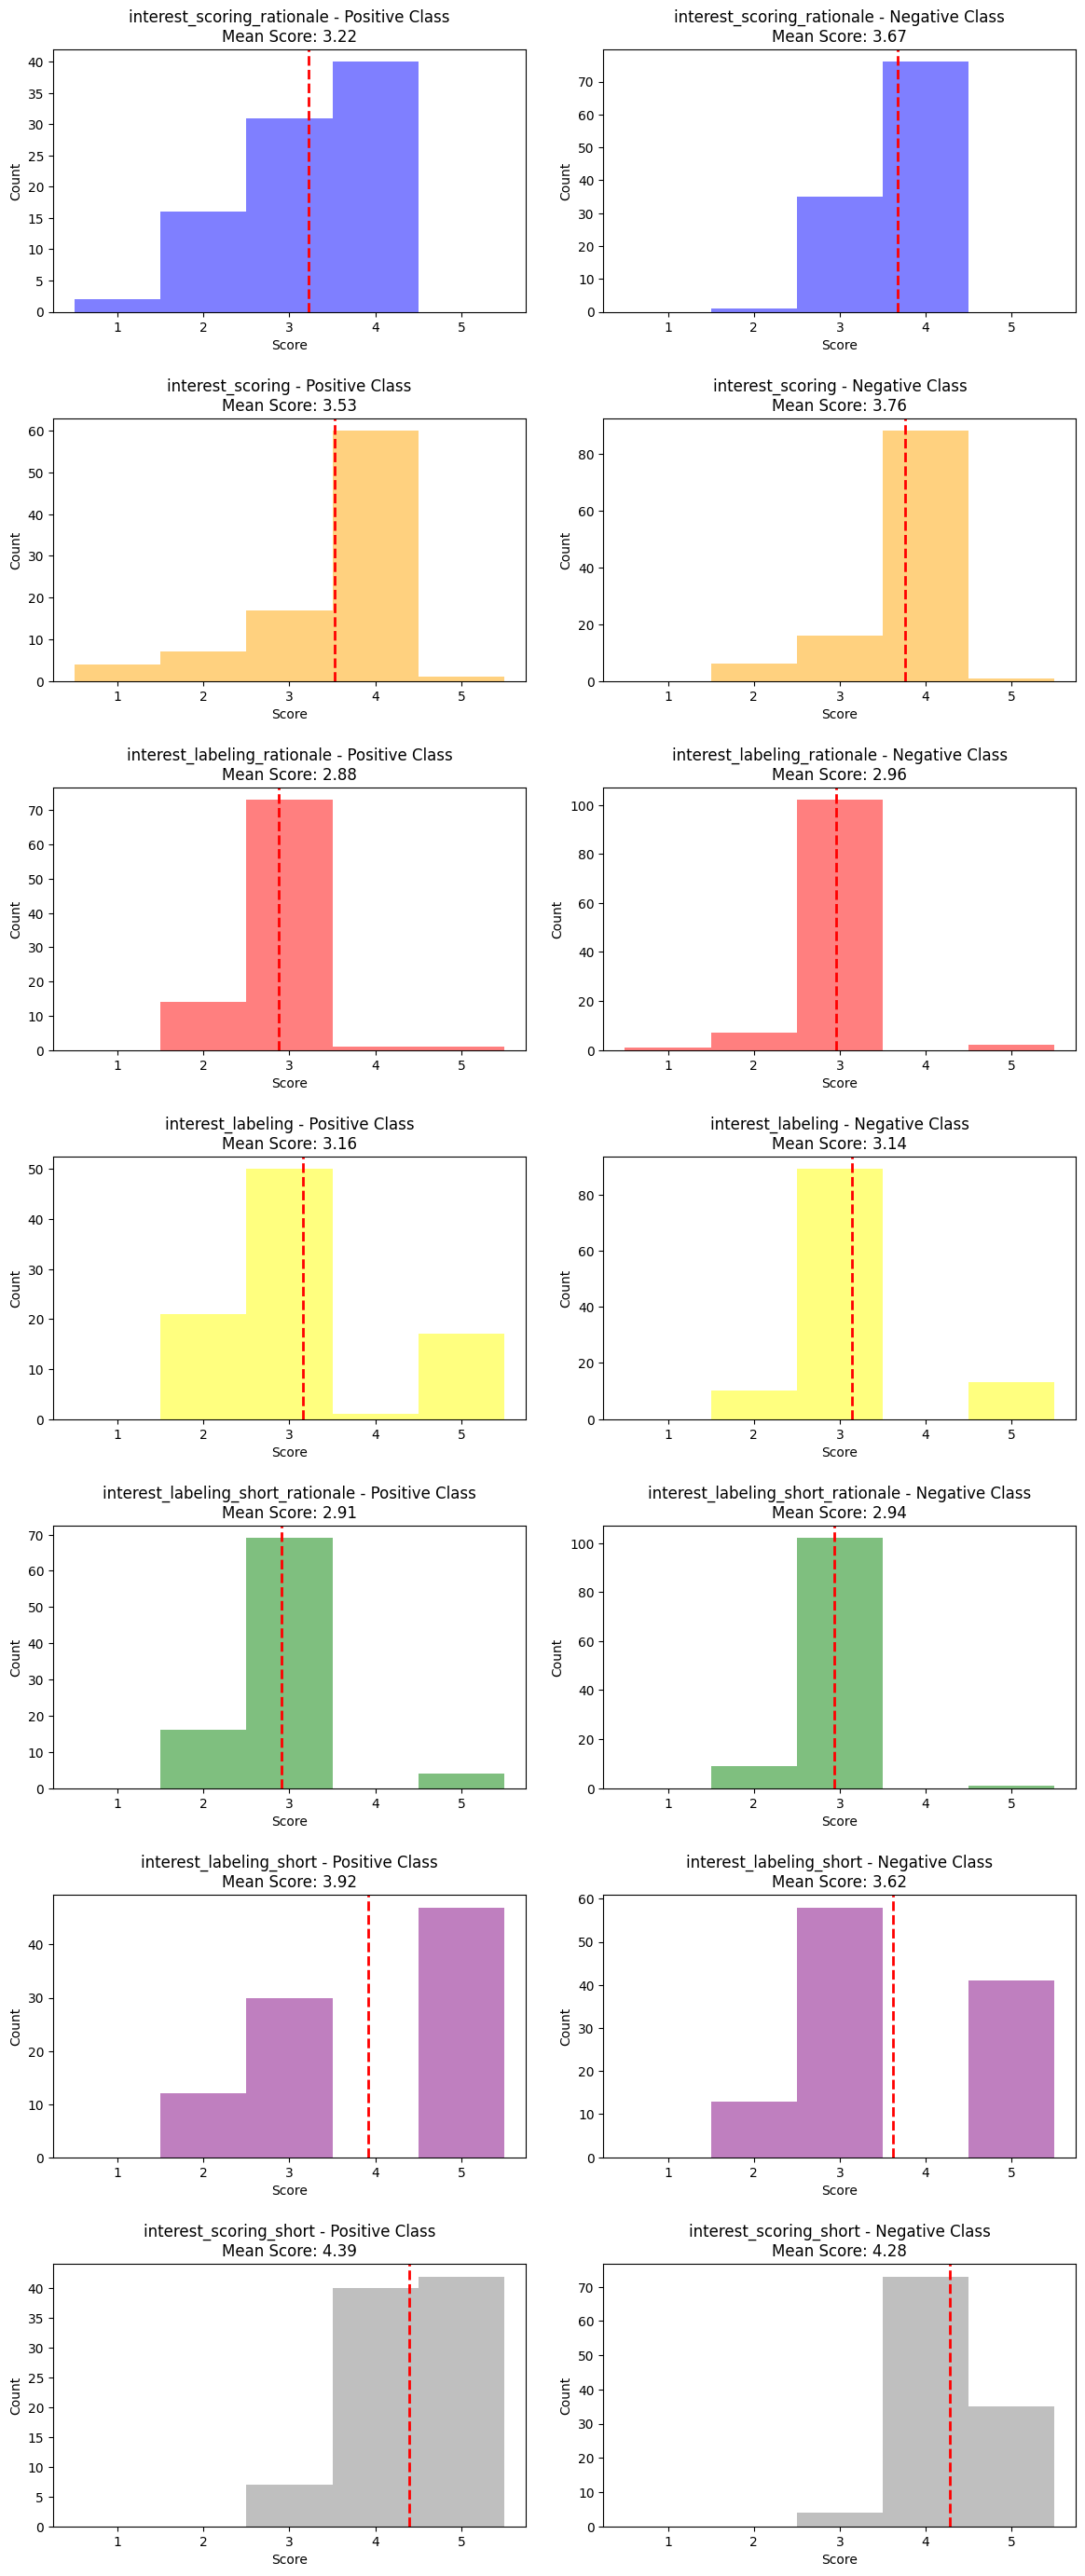

In [568]:
import matplotlib.pyplot as plt

# Calculate the number of rows needed for the subplots
n_rows = len(dataframes)
n_cols = 2  # We want 2 columns of subplots

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 4*n_rows))  # Adjust the figure size as needed

for i, (df, name, color) in enumerate(zip(dataframes, names, colors)):
    # Split the data into positive and negative classes
    positive_df = df[df['label'] == 1]
    negative_df = df[df['label'] == -1]

    # Calculate mean scores
    positive_mean = positive_df['score'].mean()
    negative_mean = negative_df['score'].mean()

    # Create histogram for positive class
    axs[i, 0].hist(positive_df['score'], bins=range(1, 7), align='left', color=color, alpha=0.5)
    axs[i, 0].set_title(f'{name} - Positive Class\nMean Score: {positive_mean:.2f}')
    axs[i, 0].set_xlabel('Score')
    axs[i, 0].set_ylabel('Count')
    axs[i, 0].axvline(positive_mean, color='r', linestyle='dashed', linewidth=2)

    # Create histogram for negative class
    axs[i, 1].hist(negative_df['score'], bins=range(1, 7), align='left', color=color, alpha=0.5)
    axs[i, 1].set_title(f'{name} - Negative Class\nMean Score: {negative_mean:.2f}')
    axs[i, 1].set_xlabel('Score')
    axs[i, 1].set_ylabel('Count')
    axs[i, 1].axvline(negative_mean, color='r', linestyle='dashed', linewidth=2)

# Adding some space between subplots
plt.tight_layout(pad=2.0)

# Displaying the plot
plt.show()


### Updated 5-State Prompt

In [572]:
interest_scoring_adapted = generate_interest_ratings(sublist, interest_task_description_scoring)
interest_scoring_short_adapted = generate_interest_ratings(sublist, interest_task_description_scoring_short)
interest_labeling_adapted = generate_interest_ratings(sublist, interest_task_description_labeling)
interest_labeling_short_adapted = generate_interest_ratings(sublist, interest_task_description_labeling_short)

{'id': 'chatcmpl-7XoyFfVxigeI0ZjdfPU9oAXaiDg2i', 'object': 'chat.completion', 'created': 1688295111, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '4'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 234, 'completion_tokens': 1, 'total_tokens': 235}}
{'id': 'chatcmpl-7XoyGU5VqDqEIDq2932rOzoyK71Et', 'object': 'chat.completion', 'created': 1688295112, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '4'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 273, 'completion_tokens': 1, 'total_tokens': 274}}
{'id': 'chatcmpl-7XoyGy5HXOEaxHRtOzwyXTB985iI1', 'object': 'chat.completion', 'created': 1688295112, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '4'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 253, 'completion_tokens': 1, 'total_tokens': 254}}
{'id': 'chatcmpl-7XoyH78hhYkPRouT1gNZwzafab231', 'object': 'chat

In [574]:
interest_labeling_adapted['score'] = interest_labeling_adapted['score'].map(label_mapping)
interest_labeling_short_adapted['score'] = interest_labeling_short_adapted['score'].map(label_mapping)

In [575]:
# Define the names of the DataFrames and labels for plotting
dataframes = [interest_scoring , interest_scoring_short, interest_scoring_adapted, interest_scoring_short_adapted, interest_labeling, interest_labeling_short, interest_labeling_adapted, interest_labeling_short_adapted]
names = ["interest_scoring", "interest_scoring_short", "interest_scoring_adapted", "interest_scoring_short_adapted", "interest_labeling", "interest_labeling_short", "interest_labeling_adapted", "interest_labeling_short_adapted"]
colors = ["blue", "orange", "red", "yellow", "green", "purple", "grey", "black"]

# Add labels to each DataFrame
for df in dataframes:
    df['label'] = sublist_labels.values


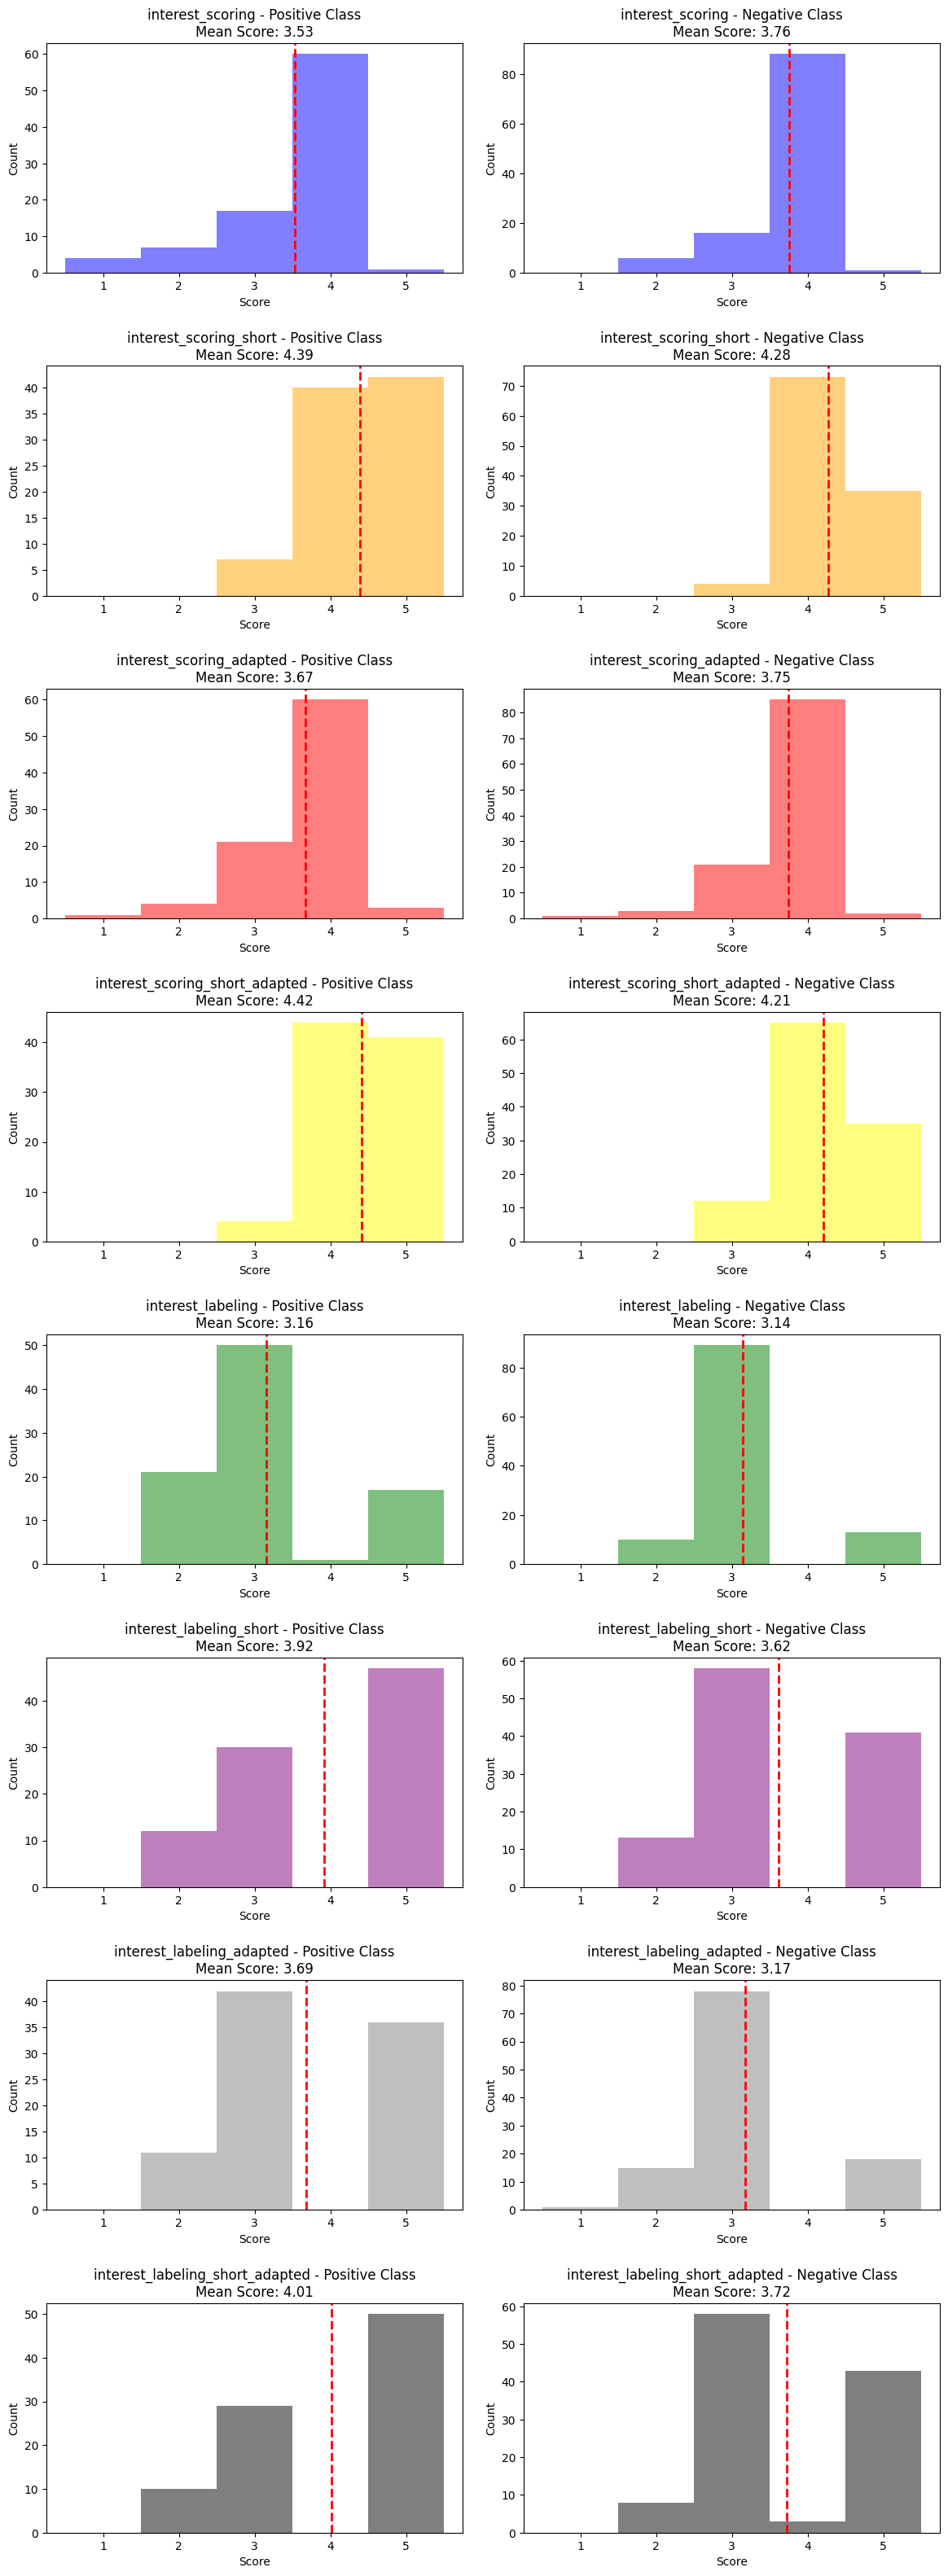

In [576]:
import matplotlib.pyplot as plt

# Calculate the number of rows needed for the subplots
n_rows = len(dataframes)
n_cols = 2  # We want 2 columns of subplots

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 4*n_rows))  # Adjust the figure size as needed

for i, (df, name, color) in enumerate(zip(dataframes, names, colors)):
    # Split the data into positive and negative classes
    positive_df = df[df['label'] == 1]
    negative_df = df[df['label'] == -1]

    # Calculate mean scores
    positive_mean = positive_df['score'].mean()
    negative_mean = negative_df['score'].mean()

    # Create histogram for positive class
    axs[i, 0].hist(positive_df['score'], bins=range(1, 7), align='left', color=color, alpha=0.5)
    axs[i, 0].set_title(f'{name} - Positive Class\nMean Score: {positive_mean:.2f}')
    axs[i, 0].set_xlabel('Score')
    axs[i, 0].set_ylabel('Count')
    axs[i, 0].axvline(positive_mean, color='r', linestyle='dashed', linewidth=2)

    # Create histogram for negative class
    axs[i, 1].hist(negative_df['score'], bins=range(1, 7), align='left', color=color, alpha=0.5)
    axs[i, 1].set_title(f'{name} - Negative Class\nMean Score: {negative_mean:.2f}')
    axs[i, 1].set_xlabel('Score')
    axs[i, 1].set_ylabel('Count')
    axs[i, 1].axvline(negative_mean, color='r', linestyle='dashed', linewidth=2)

# Adding some space between subplots
plt.tight_layout(pad=2.0)

# Displaying the plot
plt.show()


### Reduced 3-State Prompt

In [643]:
def extract_label_updated(text):
    # Define a list of labels
    labels = ["Very interesting", "Moderately interesting", "Not very interesting"]

    # Combine the labels into a regex pattern
    pattern = '|'.join(labels)

    # Search the text for the labels
    match = re.match(pattern, text)

    # If a label is found, return it. Otherwise, return None.
    if match:
        return match.group()
    else:
        return None


In [834]:
import time
import numpy as np

def generate_interest_ratings_updated(sublist, task_description, model = "gpt-3.5-turbo"):
    
    # Define results 
    if (task_description == interest_task_description_scoring_rationale or 
        task_description == interest_task_description_labeling_rationale or 
        task_description == interest_task_description_labeling_short_rationale):
        results = {
            'tweet': [],
            'score': [],
            'rationale': []
        }
    else: 
        results = {
            'tweet': [],
            'score': [],
        }

    # API call for every tweet
    for tweet in sublist: 
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {OPENAI_API_KEY}"
        }

        content = interest_system_prompt + "\nYou are given this tweet: ###\n" + tweet + "\n###\n" + task_description

        data = {
            "model": model,
            "messages": [{"role": "user", "content": f"{content}"}],
            "max_tokens": 512,
            "temperature": 0.2
        }

        success = False
        for attempt in range(3):  # Retry up to 3 times
            try: 
                response = requests.post('https://api.openai.com/v1/chat/completions', 
                                         headers=headers, 
                                         data=json.dumps(data),
                                         timeout=30)  # Setting a timeout
                answer = response.json()['choices'][0]['message']['content']
                print(response.json())
                success = True  # If successful, break out of the retry loop
                break
            except requests.exceptions.Timeout:
                print("The request timed out.")
                time.sleep(1)  # Wait for 1 second before retrying
            except json.JSONDecodeError:
                print("Couldn't decode the response as JSON")
                time.sleep(1)  # Wait for 1 second before retrying
            except KeyError:
                print("There was an error with the API call.")
                print("Full response:")
                print(response.json())
                time.sleep(1)  # Wait for 1 second before retrying

        results["tweet"].append(tweet)
        # Scoring rational
        if success and task_description == interest_task_description_scoring_rationale:
            results["rationale"].append(answer)
            digit_match = re.search(r'\d', answer)
            if digit_match is not None:  # If a digit was found in the string
                first_digit = digit_match.group()  # Extract the matched digit
                results["score"].append(int(first_digit))
            else:
                results["score"].append(None)
        # Labeling rationale
        elif success and (task_description == interest_task_description_labeling_rationale or task_description == interest_task_description_labeling_short_rationale):
            results["rationale"].append(answer)
            results["score"].append(extract_label_updated(answer))
        # scoring
        elif success and (task_description == interest_task_description_scoring or task_description == interest_task_description_scoring_short):
            if answer.isdigit():
                results["score"].append(int(answer))
            else: 
                # If not, split the string and convert to integer
                answer = re.findall(r'\d', answer)
                if answer:
                    results["score"].append(int(answer[0]))
                else:
                    results["score"].append(np.nan)
        # labeling
        elif success and (task_description == interest_task_description_labeling or task_description == interest_task_description_labeling_short):
            results["score"].append(answer)
        else:
            print(f"Failed to retrieve a score for tweet {tweet} after 3 attempts.")
            results["score"].append(np.nan)  # Append NaN if all attempts failed
            if task_description == interest_task_description_scoring_rationale: # Append NaN if all attempts failed
                results["rationale"].append(np.nan) 
    
    return pd.DataFrame(results)


In [835]:
sublist = feature_df[400:451]['preprocessed']
sublist_labels = feature_df[400:451]['label']
sublist

400    "The group’s worst case scenario, a 6-month di...
401    There’s still time to register for today’s web...
402      I'm unvaccinated, have not gotten COVID. Mos...
403    Modi claims 1 crore corona patients have been ...
404    We have to ensure every worker called back on ...
405    8️⃣ August\n\nWithin hours of the deadly explo...
406      Heres an idea! We do what we need to do to k...
407    RT : Are you concerned about possible COVID19 ...
408    1⃣ Antibiotics don’t prevent or treat COVID-19...
409    RT : We are doing extra testing in areas where...
410          No, not a grand scale. But enough to mak...
411    Only 38% Pakistanis can recall state helpline ...
412     We didn't elect Serial Liar, Perjurer, Collud...
413    Today, we are StrongerTogether\nToday, we are ...
414    We know so much more about COVID19 virus now &...
415    RT : While we are searching for COVID19 treatm...
416    31 Dec 2019: China reported a cluster of cases...
417    RT : During the national

In [629]:
interest_labels = "Very interesting, Moderately interesting, Not very interesting"

interest_system_prompt = """ You are an expert at evaluating the interestingness of tweets. """

interest_key_elements = """ And these key elements:
1) Relevance: Would this tweet create very substantial changes of beliefs if it were true for most people reading it? Is it plausible enough to make people think?
2) Novelty: Does the tweet present new, unexpected information or perspectives for most people? 
3) Emotional Content: Does the tweet elicit strong emotional responses, such as excitement, humor, shock, controversy, or other feelings that can trigger interest? \n """

interest_task_description_labeling_rationale = interest_key_elements + f"""Your job is to correctly label the provided input example into one of the following categories: {interest_labels} 
Carefully read the text of the tweet, paying close attention to details. 
Then, assign the tweet label based on above key elements.   
Before you answer, think step by step. 
You will first return the label for the given example and then provide a brief reasoning for your choice. Label: """

interest_task_description_labeling = interest_key_elements + f"""Your job is to correctly label the provided input example into one of the following categories: {interest_labels} 
Carefully read the text of the tweet, paying close attention to details. 
Then, assign the tweet label based on above key elements.
Assign "Not very interesting" if you find nothing particularly interesting about the tweet or are unsure. 
Before you answer, think step by step. 
You will just return one line consisting of the label for the given example without any further text or explanation."""

interest_task_description_labeling_short_rationale = f"""Your job is to correctly label the provided input example into one of the following categories: {interest_labels} 
Carefully read the text of the tweet, paying close attention to details. 
Then, assign the tweet label based on whether it is likely to catch someone's attention, 
arouse curiosity, seems novel, unexpected, witty or emotionally engaging. 
If you are unsure, assign "Not very interesting".  
Before you answer, think step by step. 
You will first return the label for the given example and then provide a brief reasoning for your choice. Label: """

interest_task_description_labeling_short = f"""Your job is to correctly label the provided input example into one of the following categories: {interest_labels} 
Carefully read the text of the tweet, paying close attention to details. 
Then, assign the tweet label based on whether it is likely to catch someone's attention, 
arouse curiosity, seems novel, unexpected, witty or emotionally engaging. 
If you are unsure, assign "Not very interesting".  
Before you answer, think step by step. 
You will just return one line consisting of the label for the given example without any further text or explanation."""


In [651]:
interest_labeling_rationale_three_labels = generate_interest_ratings_updated(sublist, interest_task_description_labeling_rationale)

{'id': 'chatcmpl-7Y9nXf23VeeiE5DxHC1Xvl0c5q7d6', 'object': 'chat.completion', 'created': 1688375171, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Moderately interesting\n\nReasoning:\n1) Relevance: This tweet could potentially create substantial changes of beliefs for most people reading it. The claim that a 6-month disruption of antiretroviral therapy could lead to 500,000 extra deaths from AIDS-related illnesses in sub-Saharan Africa is a significant and alarming statement. It is plausible enough to make people think about the potential consequences of such a disruption.\n2) Novelty: The information presented in the tweet is not entirely new or unexpected. The fact that disruptions in antiretroviral therapy can have severe consequences for AIDS-related illnesses is known. However, the specific number of 500,000 extra deaths and the mention of tuberculosis as one of the illnesses are new details that may be unexpected for some re

In [652]:
interest_labeling_three_labels = generate_interest_ratings_updated(sublist, interest_task_description_labeling)

{'id': 'chatcmpl-7Y9tn2m1S18xBkm3LY5RNACOYA5eL', 'object': 'chat.completion', 'created': 1688375559, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Very interesting'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 278, 'completion_tokens': 2, 'total_tokens': 280}}
{'id': 'chatcmpl-7Y9toL8idDUPAuXpqfaycJSPhBPcT', 'object': 'chat.completion', 'created': 1688375560, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Moderately interesting'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 276, 'completion_tokens': 3, 'total_tokens': 279}}
{'id': 'chatcmpl-7Y9tpBgyGH8yD288Tc7iVVUB4AHfF', 'object': 'chat.completion', 'created': 1688375561, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Moderately interesting'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 281, 'completion_tokens': 3, 'total_tokens': 284}}
{'id': 

In [653]:
interest_labeling_rationale_short_three_labels = generate_interest_ratings_updated(sublist, interest_task_description_labeling_short_rationale)

{'id': 'chatcmpl-7Y9uvHYjqqAqhdGl7YNPgfIoIQVac', 'object': 'chat.completion', 'created': 1688375629, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': "Moderately interesting\n\nReasoning:\nThe tweet discusses the potential consequences of a 6-month disruption of antiretroviral therapy in sub-Saharan Africa, which could result in 500,000 extra deaths from AIDS-related illnesses, including tuberculosis. This information is likely to catch someone's attention as it highlights the potential impact of the disruption on public health. It also raises concerns about the consequences of the COVID-19 pandemic on other healthcare issues. However, the tweet lacks elements of novelty, unexpectedness, wit, or emotional engagement, which would make it more interesting. Therefore, it is categorized as moderately interesting."}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 203, 'completion_tokens': 123, 'total_tokens': 326}}
{'id': 'chatcmpl-7

In [654]:
interest_labeling_short_three_labels = generate_interest_ratings_updated(sublist, interest_task_description_labeling_short)

{'id': 'chatcmpl-7Y9yPnQ0l9OiuEofi2K2HaOScBPn9', 'object': 'chat.completion', 'created': 1688375845, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Very interesting'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 201, 'completion_tokens': 2, 'total_tokens': 203}}
{'id': 'chatcmpl-7Y9yPGXwOBt8Tf2ulTLrDDYuTUiLi', 'object': 'chat.completion', 'created': 1688375845, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Very interesting'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 199, 'completion_tokens': 2, 'total_tokens': 201}}
{'id': 'chatcmpl-7Y9yQh9CDKw651EE339hoa8dfKMk0', 'object': 'chat.completion', 'created': 1688375846, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Moderately interesting'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 204, 'completion_tokens': 3, 'total_tokens': 207}}
{'id': 'chatc

In [656]:
# Define mapping dictionary
label_mapping = {
    "Very interesting.": 2,
    "Very interesting": 2,
    "Moderately interesting.": 1,
    "Moderately interesting": 1,
    "Not very interesting.": 0,
    "Not very interesting": 0
}

# Suppose df is your DataFrame and 'labels' is the column that contains the labels
interest_labeling_rationale_three_labels['score'] = interest_labeling_rationale_three_labels['score'].map(label_mapping)
interest_labeling_three_labels['score'] = interest_labeling_three_labels['score'].map(label_mapping)
interest_labeling_rationale_short_three_labels['score'] = interest_labeling_rationale_short_three_labels['score'].map(label_mapping)
interest_labeling_short_three_labels['score'] = interest_labeling_short_three_labels['score'].map(label_mapping)


In [658]:
# Define the names of the DataFrames and labels for plotting
dataframes = [interest_labeling_rationale_three_labels , interest_labeling_three_labels, interest_labeling_rationale_short_three_labels, interest_labeling_short_three_labels]
names = ["interest_labeling_rationale_three_labels", "interest_labeling_three_labels", "interest_labeling_rationale_short_three_labels", "interest_labeling_short_three_labels"]
colors = ["blue", "orange", "red", "purple"]

# Add labels to each DataFrame
for df in dataframes:
    df['label'] = sublist_labels.values


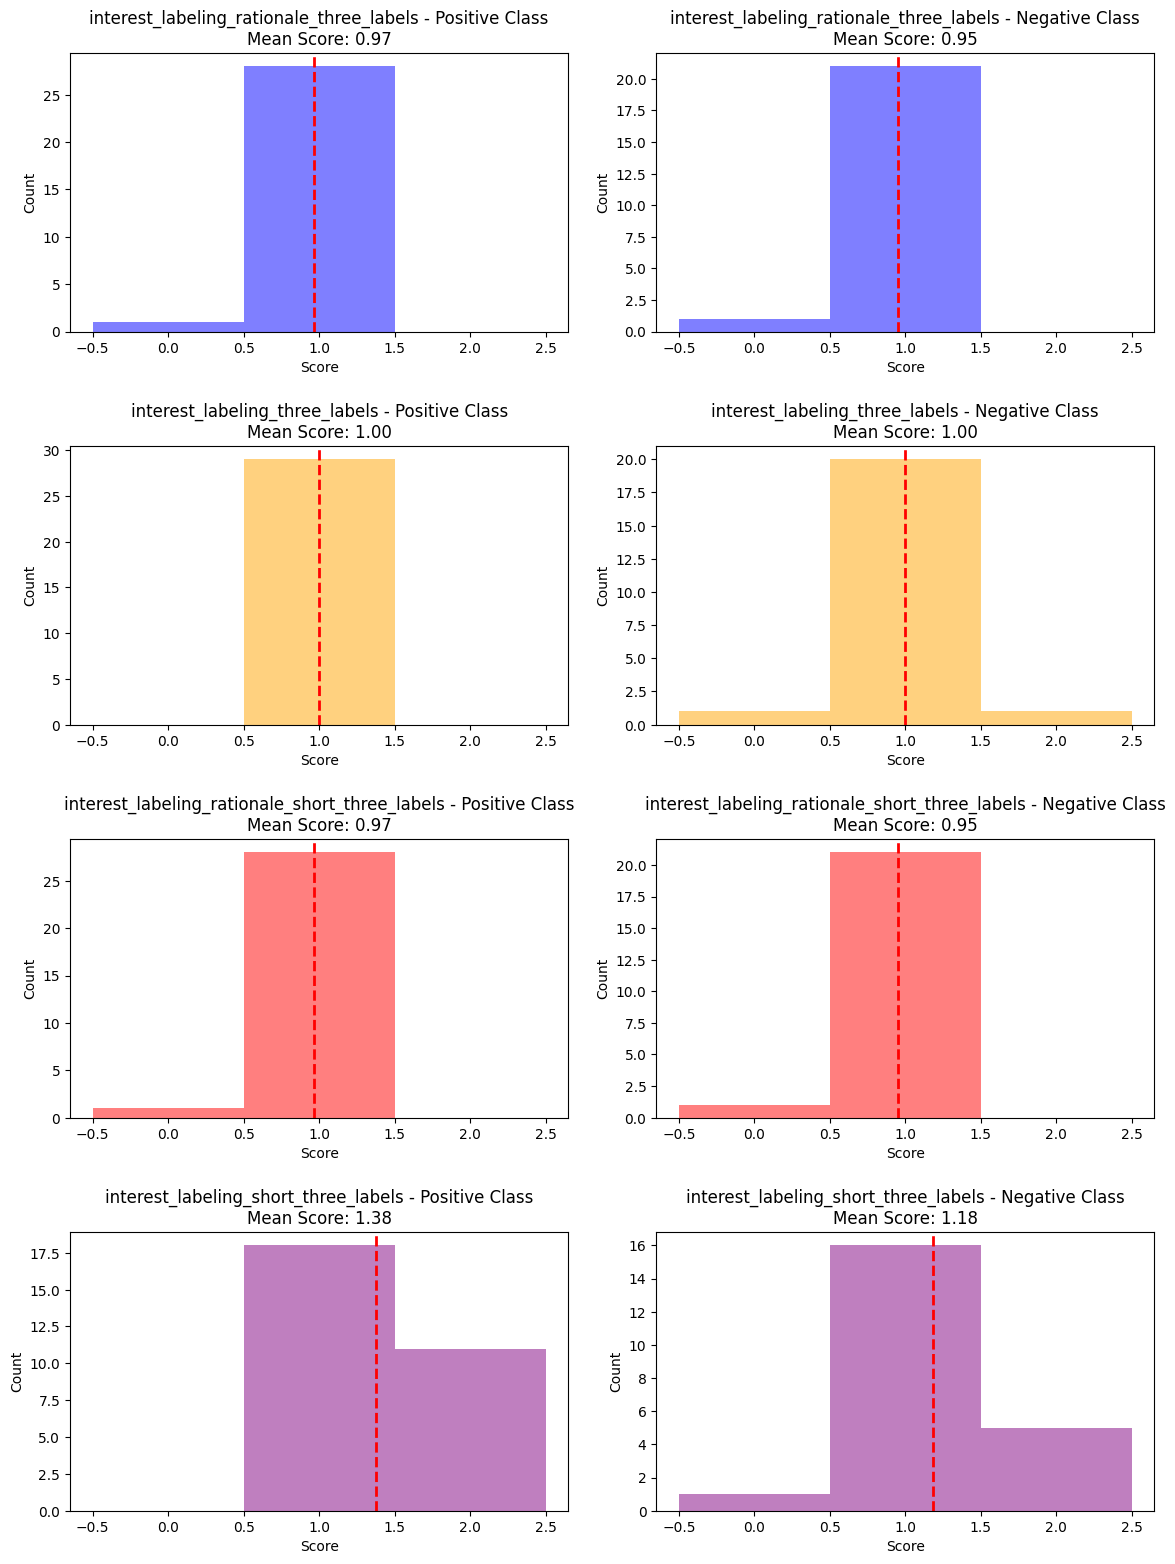

In [659]:
import matplotlib.pyplot as plt

# Calculate the number of rows needed for the subplots
n_rows = len(dataframes)
n_cols = 2  # We want 2 columns of subplots

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 4*n_rows))  # Adjust the figure size as needed

for i, (df, name, color) in enumerate(zip(dataframes, names, colors)):
    # Split the data into positive and negative classes
    positive_df = df[df['label'] == 1]
    negative_df = df[df['label'] == -1]

    # Calculate mean scores
    positive_mean = positive_df['score'].mean()
    negative_mean = negative_df['score'].mean()

    # Create histogram for positive class
    axs[i, 0].hist(positive_df['score'], bins=range(0, 4), align='left', color=color, alpha=0.5)
    axs[i, 0].set_title(f'{name} - Positive Class\nMean Score: {positive_mean:.2f}')
    axs[i, 0].set_xlabel('Score')
    axs[i, 0].set_ylabel('Count')
    axs[i, 0].axvline(positive_mean, color='r', linestyle='dashed', linewidth=2)

    # Create histogram for negative class
    axs[i, 1].hist(negative_df['score'], bins=range(0, 4), align='left', color=color, alpha=0.5)
    axs[i, 1].set_title(f'{name} - Negative Class\nMean Score: {negative_mean:.2f}')
    axs[i, 1].set_xlabel('Score')
    axs[i, 1].set_ylabel('Count')
    axs[i, 1].axvline(negative_mean, color='r', linestyle='dashed', linewidth=2)

# Adding some space between subplots
plt.tight_layout(pad=2.0)

# Displaying the plot
plt.show()


### Final Prompt 

In [844]:
# Define range
start = 0
end = 10

In [845]:
# Define sublist to encode 
sublist = feature_df[start:end]['preprocessed']
sublist_labels = feature_df[start:end]['label']
sublist

0    The drive-through coronavirus testing site in ...
1    "4⃣  and WHO are exploring how the EIB could s...
2                     Media briefing on COVID19 with  
3    RT : The new NHSCOVID19app, now available in E...
4               Dr. Yan presented evidence Covid 19...
5    Youve seen whats going on in New Zealand? Big ...
6    We are expanding the range of healthcare worke...
7    Facts can get distorted. \n\n⏸️Pause. TakeCare...
8    New cases of coronavirus in Madrid are linked ...
9    First Case Of Coronavirus For Family Pet Dog� ...
Name: preprocessed, dtype: object

In [838]:
interest_labels = "Very interesting, Moderately interesting, Not very interesting"

interest_system_prompt = """ You are an expert at evaluating the interestingness of tweets. """

interest_task_description_labeling_short = f"""Your job is to correctly label the provided input example into one of the following categories: {interest_labels} 
Carefully read the text of the tweet, paying close attention to details. 
Then, assign the tweet label based on whether it is likely to catch someone's attention, 
arouse curiosity, seems novel, unexpected, witty or emotionally engaging. 
If you are unsure, assign "Not very interesting".  
Before you answer, think step by step. 
You will just return one line consisting of the label for the given example without any further text or explanation."""


In [ ]:
# # Let's take a closer look
# interest_labeling_rationale_short_three_labels
# interest_labeling_rationale_short_three_labels.to_csv('rationales_tests_labeling_short.csv')

In [849]:
# Encode 
interest_labeling_short_three_labels_final = generate_interest_ratings_updated(sublist, interest_task_description_labeling_short)

{'id': 'chatcmpl-7YWpL0fbhRaTMsrIq6jy8r7Brprh2', 'object': 'chat.completion', 'created': 1688463695, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Moderately interesting'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 182, 'completion_tokens': 3, 'total_tokens': 185}}
{'id': 'chatcmpl-7YWpMX2dPK9HSZuGg7nREYTGgYUCn', 'object': 'chat.completion', 'created': 1688463696, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Moderately interesting'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 194, 'completion_tokens': 3, 'total_tokens': 197}}
{'id': 'chatcmpl-7YWpMyVEgGOEkar7ei24fM9s4By6p', 'object': 'chat.completion', 'created': 1688463696, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Not very interesting'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 156, 'completion_tokens': 3, 'total_tokens': 159}}
{'i

In [ ]:
# interest_labeling_short_three_labels_final_gpt_4 = generate_interest_ratings_updated(sublist, interest_task_description_labeling_short, model="gpt-4")

In [850]:
# Define mapping dictionary
label_mapping = {
    "Very interesting.": 2,
    "Very interesting": 2,
    "Moderately interesting.": 1,
    "Moderately interesting": 1,
    "Not very interesting.": 0,
    "Not very interesting": 0
}

interest_labeling_short_three_labels_final['score'] = interest_labeling_short_three_labels_final['score'].map(label_mapping)


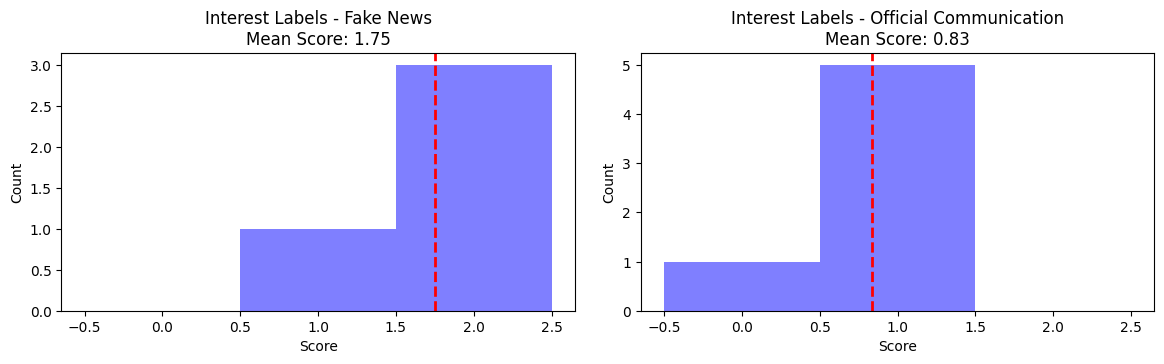

In [851]:
# Add labels 
interest_labeling_short_three_labels_final['label'] = sublist_labels.values

import matplotlib.pyplot as plt

# Define your dataframe, name and color
df = interest_labeling_short_three_labels_final
name = "Interest Labels"  # Replace with your actual dataframe name
color = 'blue'  # Replace with your desired color

fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # Adjust the figure size as needed

# Split the data into positive and negative classes
positive_df = df[df['label'] == 1]
negative_df = df[df['label'] == -1]

# Calculate mean scores
positive_mean = positive_df['score'].mean()
negative_mean = negative_df['score'].mean()

# Create histogram for positive class
axs[0].hist(positive_df['score'], bins=range(0, 4), align='left', color=color, alpha=0.5)
axs[0].set_title(f'{name} - Fake News\nMean Score: {positive_mean:.2f}')
axs[0].set_xlabel('Score')
axs[0].set_ylabel('Count')
axs[0].axvline(positive_mean, color='r', linestyle='dashed', linewidth=2)

# Create histogram for negative class
axs[1].hist(negative_df['score'], bins=range(0, 4), align='left', color=color, alpha=0.5)
axs[1].set_title(f'{name} - Official Communication\nMean Score: {negative_mean:.2f}')
axs[1].set_xlabel('Score')
axs[1].set_ylabel('Count')
axs[1].axvline(negative_mean, color='r', linestyle='dashed', linewidth=2)

# Adding some space between subplots
plt.tight_layout(pad=2.0)

# Displaying the plot
plt.show()



In [734]:
interest_labeling_short_three_labels_final.isna().sum()

tweet    0
score    0
label    0
dtype: int64

### Investigate Usefulness

#### Overview

In [753]:
subset = feature_df[start:end]
subset['interest'] = interest_labeling_short_three_labels_final['score']

/var/folders/px/by1fmlxd5ggfyj8p6_c8m_zh0000gn/T/ipykernel_46459/4257099209.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['interest'] = interest_labeling_short_three_labels_final['score']


/var/folders/px/by1fmlxd5ggfyj8p6_c8m_zh0000gn/T/ipykernel_46459/894909835.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = subset.corr()


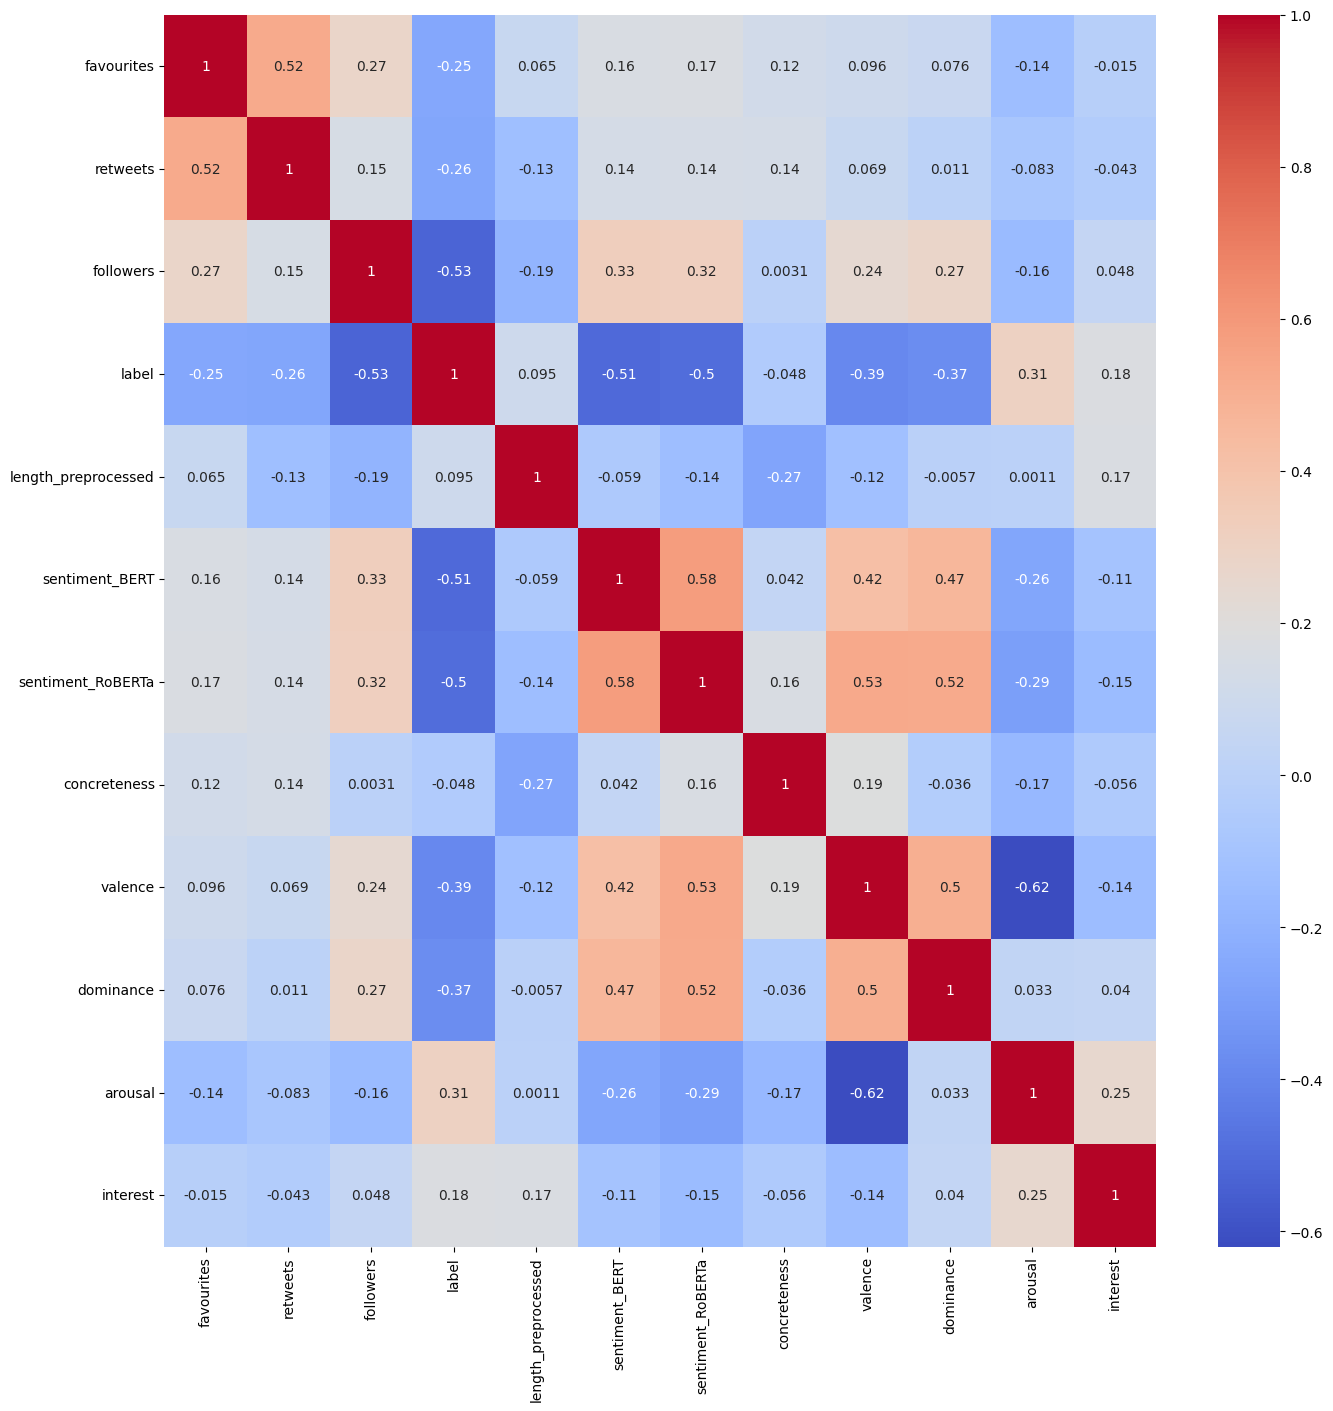

In [708]:
import seaborn as sns

correlation_matrix = subset.corr()

plt.figure(figsize=(16, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


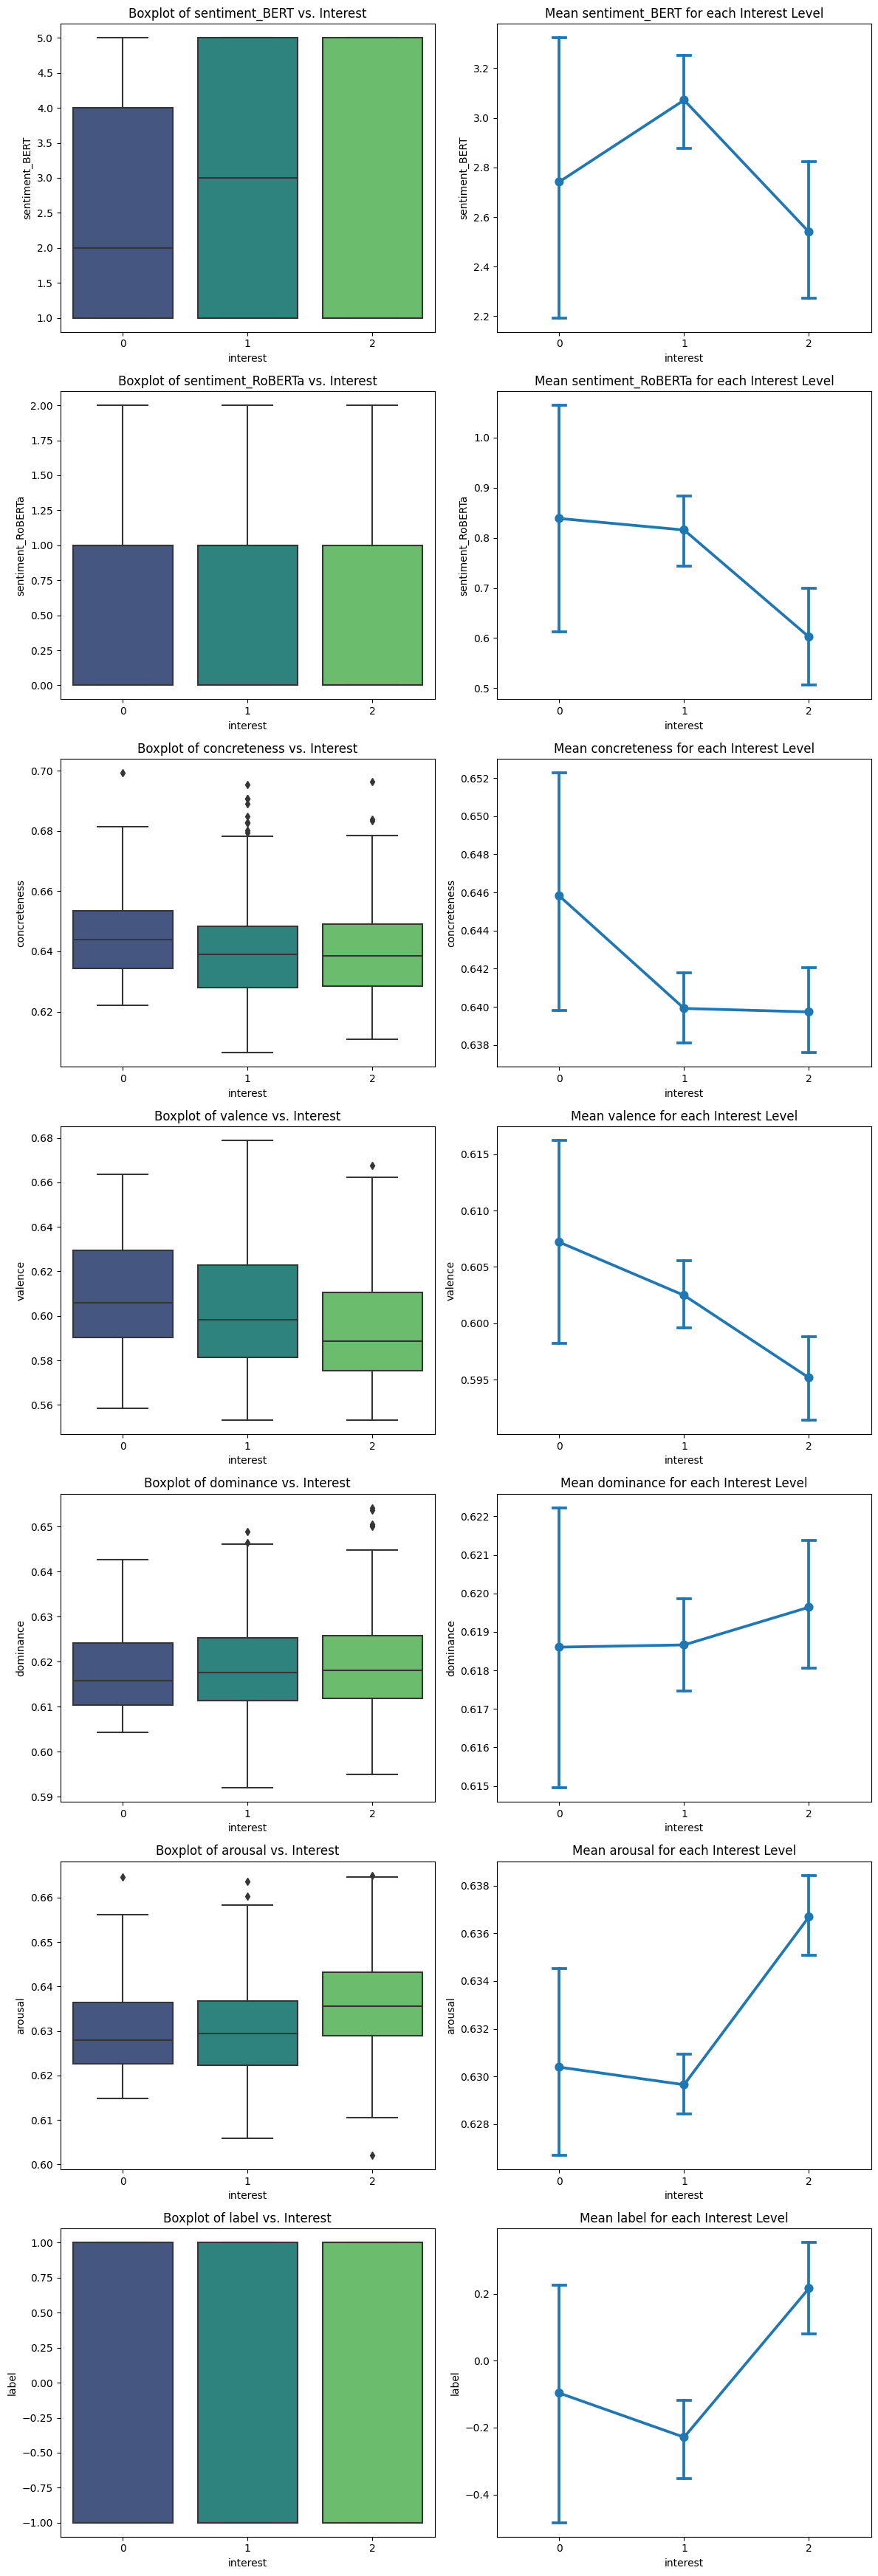

In [739]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of columns to plot
cols = ['sentiment_BERT', 'sentiment_RoBERTa', 'concreteness', 'valence', 'dominance', 'arousal', 'label']

# Create subplots
fig, axes = plt.subplots(len(cols), 2, figsize=(12, len(cols)*5))  # 2 columns for boxplot and mean pointplot

# Iterate over each column and create a plot
for i, col in enumerate(cols):
    sns.boxplot(x='interest', y=col, data=subset, ax=axes[i, 0], palette='viridis')
    axes[i, 0].set_title(f'Boxplot of {col} vs. Interest')

    sns.pointplot(x='interest', y=col, data=subset, ax=axes[i, 1], capsize=.1)
    axes[i, 1].set_title(f'Mean {col} for each Interest Level')

plt.tight_layout()
plt.show()


In [754]:
subset = subset[['label', 'interest']]
# subset = subset[['label', 'sentiment_BERT', 'sentiment_RoBERTa', 'concreteness', 'valence', 'dominance', 'arousal', 'interest']]

#### Official versus Fake Prediction

In [755]:
### Linear SVM

# Define your feature set and target variable
features = subset.columns.drop('label')
X = subset[features]
y = subset['label']

print(X)

     interest
0           2
1           1
2           0
3           1
4           2
..        ...
495         1
496         1
497         1
498         2
499         2

[500 rows x 1 columns]


In [756]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets (shuffle by default)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [757]:
from sklearn.svm import LinearSVC

# Create and fit the model
model = LinearSVC(random_state=42, class_weight='balanced')

In [758]:
# Fit model with final features and get accuracy
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [759]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, classification_report
from sklearn.metrics import accuracy_score

# Calculate and print F1 score
acc = accuracy_score(y_test, y_pred)
print(f'The accuracy score of the Linear SVM model with selected features is: {acc:.4f}')

# Calculate and print F1 score
f1 = f1_score(y_test, y_pred, average='macro')
print(f'The F1 score of the Linear SVM model with selected features is: {f1:.4f}')

# Calculate and print precision
precision = precision_score(y_test, y_pred, average='macro')
print(f'The precision of the Linear SVM model with selected features is: {precision:.4f}')

# Calculate and print recall
recall = recall_score(y_test, y_pred, average='macro')
print(f'The recall of the Linear SVM model with selected features is: {recall:.4f}')

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix:')
print(cm)

# Classification Report
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

The accuracy score of the Linear SVM model with selected features is: 0.6100
The F1 score of the Linear SVM model with selected features is: 0.5793
The precision of the Linear SVM model with selected features is: 0.6030
The recall of the Linear SVM model with selected features is: 0.5860

Confusion Matrix:
[[44 12]
 [27 17]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.62      0.79      0.69        56
           1       0.59      0.39      0.47        44

    accuracy                           0.61       100
   macro avg       0.60      0.59      0.58       100
weighted avg       0.60      0.61      0.59       100



#### Predict interestingness

In [764]:
subset = feature_df[start:end]
subset['interest'] = interest_labeling_short_three_labels_final['score']

/var/folders/px/by1fmlxd5ggfyj8p6_c8m_zh0000gn/T/ipykernel_46459/4257099209.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['interest'] = interest_labeling_short_three_labels_final['score']


In [765]:
subset = subset[['label', 'sentiment_BERT', 'sentiment_RoBERTa', 'concreteness', 'valence', 'dominance', 'arousal', 'interest']]

In [766]:
### Linear SVM

# Define your feature set and target variable
features = subset.columns.drop('label').drop('interest')
X = subset[features]
y = subset['interest']

print(X)

     sentiment_BERT  sentiment_RoBERTa  concreteness   valence  dominance  \
0                 4                  1      0.652198  0.606417   0.630947   
1                 5                  1      0.642415  0.646490   0.634640   
2                 4                  1      0.647267  0.633763   0.618594   
3                 5                  1      0.646969  0.610125   0.617799   
4                 1                  1      0.644149  0.609986   0.621102   
..              ...                ...           ...       ...        ...   
495               4                  1      0.640112  0.599750   0.614110   
496               5                  1      0.665521  0.610660   0.612843   
497               5                  1      0.630851  0.566912   0.629442   
498               2                  1      0.628180  0.578553   0.610504   
499               1                  1      0.665221  0.571552   0.623133   

      arousal  
0    0.626204  
1    0.612494  
2    0.622606  
3    0.6323

In [767]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets (shuffle by default)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

In [768]:
from sklearn.preprocessing import StandardScaler

# Standardize the features to have zero mean and unit variance
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [769]:
from sklearn.svm import LinearSVC

# Create and fit the model
model = LinearSVC(random_state=42, class_weight='balanced')

In [770]:
# Fit model with final features and get accuracy
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [771]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, classification_report
from sklearn.metrics import accuracy_score

# Calculate and print F1 score
acc = accuracy_score(y_test, y_pred)
print(f'The accuracy score of the Linear SVM model with selected features is: {acc:.4f}')

# Calculate and print F1 score
f1 = f1_score(y_test, y_pred, average='macro')
print(f'The F1 score of the Linear SVM model with selected features is: {f1:.4f}')

# Calculate and print precision
precision = precision_score(y_test, y_pred, average='macro')
print(f'The precision of the Linear SVM model with selected features is: {precision:.4f}')

# Calculate and print recall
recall = recall_score(y_test, y_pred, average='macro')
print(f'The recall of the Linear SVM model with selected features is: {recall:.4f}')

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix:')
print(cm)

# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred))

The accuracy score of the Linear SVM model with selected features is: 0.6200
The F1 score of the Linear SVM model with selected features is: 0.4708
The precision of the Linear SVM model with selected features is: 0.4786
The recall of the Linear SVM model with selected features is: 0.4660

Confusion Matrix:
[[ 1  3  2]
 [ 3 44 12]
 [ 1 17 17]]
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.17      0.18         6
           1       0.69      0.75      0.72        59
           2       0.55      0.49      0.52        35

    accuracy                           0.62       100
   macro avg       0.48      0.47      0.47       100
weighted avg       0.61      0.62      0.61       100



## Novelty

#### Prompt Crafting

In [778]:
novelty_labels = "Very novel, Moderately novel, Not very novel"

novelty_system_prompt = """ You are an expert at evaluating the novelty and surprise of tweets. """

novelty_task_description_labeling_short = f"""Your job is to correctly label the provided input example into one of the following categories: {novelty_labels} 
Carefully read the text of the tweet, paying close attention to details. 
Then, assign the tweet label based on whether the tweet contains novel or surprising information or makes a puzzling statement. 
If you are unsure, assign "Not very novel".  
Before you answer, think step by step. 
You will just return one line consisting of the label for the given example without any further text or explanation."""

In [780]:
import time
import numpy as np

def generate_novelty_final(sublist, task_description, model = "gpt-3.5-turbo"):
    
    results = {
        'tweet': [],
        'score': [],
    }

    # API call for every tweet
    for tweet in sublist: 
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {OPENAI_API_KEY}"
        }

        content = novelty_system_prompt + "\nYou are given this tweet: ###\n" + tweet + "\n###\n" + task_description

        data = {
            "model": model,
            "messages": [{"role": "user", "content": f"{content}"}],
            "max_tokens": 512,
            "temperature": 0.7
        }

        success = False
        for attempt in range(3):  # Retry up to 3 times
            try: 
                response = requests.post('https://api.openai.com/v1/chat/completions', 
                                         headers=headers, 
                                         data=json.dumps(data),
                                         timeout=30)  # Setting a timeout
                answer = response.json()['choices'][0]['message']['content']
                print(response.json())
                success = True  # If successful, break out of the retry loop
                break
            except requests.exceptions.Timeout:
                print("The request timed out.")
                time.sleep(1)  # Wait for 1 second before retrying
            except json.JSONDecodeError:
                print("Couldn't decode the response as JSON")
                time.sleep(1)  # Wait for 1 second before retrying
            except KeyError:
                print("There was an error with the API call.")
                print("Full response:")
                print(response.json())
                time.sleep(1)  # Wait for 1 second before retrying

        results["tweet"].append(tweet)
        
        # labeling
        if success:
            results["score"].append(answer)
        else:
            print(f"Failed to retrieve a label for tweet {tweet} after 3 attempts.")
            results["score"].append(np.nan)  # Append NaN if all attempts failed
    
    return pd.DataFrame(results)


In [792]:
sublist_novelty = feature_df[2000:2250]['preprocessed']
sublist_labels_novelty = feature_df[2000:2250]['label']

In [793]:
novelty_labeling_short = generate_novelty_final(sublist_novelty, novelty_task_description_labeling_short)

{'id': 'chatcmpl-7YUfBAZckoulyrg2nJLLixwnzu53U', 'object': 'chat.completion', 'created': 1688455377, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Not very novel'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 198, 'completion_tokens': 3, 'total_tokens': 201}}
{'id': 'chatcmpl-7YUfCG70Wlxax7jg3itqpkCMvUpv5', 'object': 'chat.completion', 'created': 1688455378, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Very novel'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 204, 'completion_tokens': 2, 'total_tokens': 206}}
{'id': 'chatcmpl-7YUfCkFEbr4PPikL8aENFcPSnOBJc', 'object': 'chat.completion', 'created': 1688455378, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Not very novel'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 190, 'completion_tokens': 3, 'total_tokens': 193}}
{'id': 'chatcmpl-7YUfDDill8Tg

In [794]:
# Define mapping dictionary
label_mapping_novelty = {
    "Very novel.": 2,
    "Very novel": 2,
    "Moderately novel.": 1,
    "Moderately novel": 1,
    "Not very novel.": 0,
    "Not very novel": 0
}

# Suppose df is your DataFrame and 'labels' is the column that contains the labels
novelty_labeling_short['score'] = novelty_labeling_short['score'].map(label_mapping_novelty)

#### Results

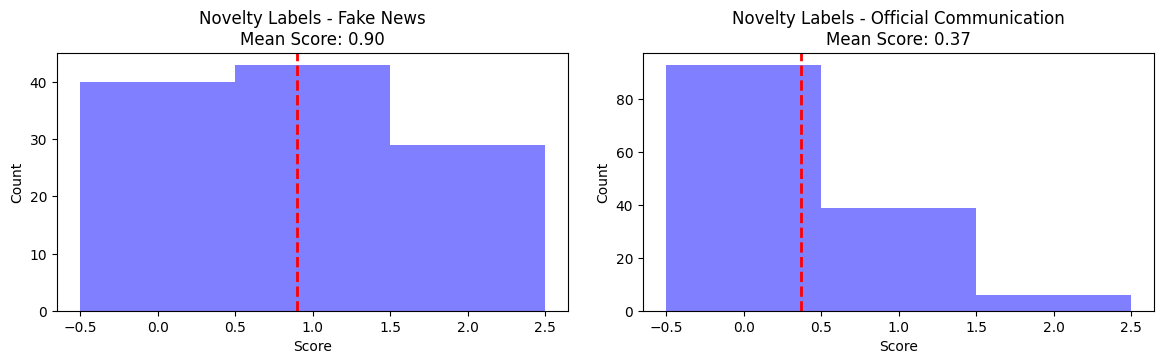

In [795]:
# Add labels 
novelty_labeling_short['label'] = sublist_labels_novelty.values

# Define your dataframe, name and color
df = novelty_labeling_short
name = "Novelty Labels"  # Replace with your actual dataframe name
color = 'blue'  # Replace with your desired color

fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # Adjust the figure size as needed

# Split the data into positive and negative classes
positive_df = df[df['label'] == 1]
negative_df = df[df['label'] == -1]

# Calculate mean scores
positive_mean = positive_df['score'].mean()
negative_mean = negative_df['score'].mean()

# Create histogram for positive class
axs[0].hist(positive_df['score'], bins=range(0, 4), align='left', color=color, alpha=0.5)
axs[0].set_title(f'{name} - Fake News\nMean Score: {positive_mean:.2f}')
axs[0].set_xlabel('Score')
axs[0].set_ylabel('Count')
axs[0].axvline(positive_mean, color='r', linestyle='dashed', linewidth=2)

# Create histogram for negative class
axs[1].hist(negative_df['score'], bins=range(0, 4), align='left', color=color, alpha=0.5)
axs[1].set_title(f'{name} - Official Communication\nMean Score: {negative_mean:.2f}')
axs[1].set_xlabel('Score')
axs[1].set_ylabel('Count')
axs[1].axvline(negative_mean, color='r', linestyle='dashed', linewidth=2)

# Adding some space between subplots
plt.tight_layout(pad=2.0)

# Displaying the plot
plt.show()



## Relevance

In [ ]:
# Example: If the tweet "Especially when masks make barely ANY difference to the spread of covid but do have many negative impacts on children and there is no denying that." 
# were true, it would change the mainstream belief that masks are an effective tool in fighting the Covid-19 spread. 
# Label: Very strong    
# Example: Conversly, the tweet "We've an important task ahead of us to empower & resource all health workforces across the world." is important and accurate but
# as it is the mainstream belief already, it would't lead to signficant changes of mind.
# Label: Not very strong

In [875]:
change_of_mind_labels = "Very strong, Moderately strong, Not very strong"

change_of_mind_system_prompt = """ You are an expert at evaluating the potential change of mind a tweet might cause. """

change_of_mind_task_description_labeling_short = f"""Your job is to correctly label the provided input example into one of the following categories: {change_of_mind_labels} 
Carefully read the text of the tweet, paying close attention to details. 
Assume, the statement in the tweet is true. 
Assign the change-of-mind label based on the degree to which the tweet is likely to lead to substantial changes in what 
people belief or how they act. 
If you are unsure, assign "Not very strong".  
Before you answer, think step by step. 
You will just return one line consisting of the label for the given example without any further text or explanation."""

########

plausibility_labels = "Very plausible, Moderately plausible, Not very plausible"

plausibility_system_prompt = """ You are an expert at evaluating the plausibility of tweet statements. """

plausibility_task_description_labeling_short = f"""Your job is to correctly label the provided input example into one of the following categories: {plausibility_labels} 
Carefully read the text of the tweet, paying close attention to details. 
Then, assign the change-of-mind label based on how plausible and accurate the statement of the tweet appears to be. 
If you are unsure, assign "Not very plausible".  
Before you answer, think step by step. 
You will just return one line consisting of the label for the given example without any further text or explanation."""

In [876]:
import time
import numpy as np

def generate_change_of_mind_final(sublist, task_description, model = "gpt-3.5-turbo"):
    
    results = {
        'tweet': [],
        'score': [],
    }

    # API call for every tweet
    for tweet in sublist: 
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {OPENAI_API_KEY}"
        }

        content = change_of_mind_system_prompt + "\nYou are given this tweet: ###\n" + tweet + "\n###\n" + task_description

        data = {
            "model": model,
            "messages": [{"role": "user", "content": f"{content}"}],
            "max_tokens": 512,
            "temperature": 0.1
        }

        success = False
        for attempt in range(3):  # Retry up to 3 times
            try: 
                response = requests.post('https://api.openai.com/v1/chat/completions', 
                                         headers=headers, 
                                         data=json.dumps(data),
                                         timeout=30)  # Setting a timeout
                answer = response.json()['choices'][0]['message']['content']
                print(response.json())
                success = True  # If successful, break out of the retry loop
                break
            except requests.exceptions.Timeout:
                print("The request timed out.")
                time.sleep(1)  # Wait for 1 second before retrying
            except json.JSONDecodeError:
                print("Couldn't decode the response as JSON")
                time.sleep(1)  # Wait for 1 second before retrying
            except KeyError:
                print("There was an error with the API call.")
                print("Full response:")
                print(response.json())
                time.sleep(1)  # Wait for 1 second before retrying

        results["tweet"].append(tweet)
        
        # labeling
        if success:
            results["score"].append(answer)
        else:
            print(f"Failed to retrieve a label for tweet {tweet} after 3 attempts.")
            results["score"].append(np.nan)  # Append NaN if all attempts failed
    
    return pd.DataFrame(results)


In [877]:
import time
import numpy as np

def generate_plausibility_final(sublist, task_description, model = "gpt-3.5-turbo"):
    
    results = {
        'tweet': [],
        'score': [],
    }

    # API call for every tweet
    for tweet in sublist: 
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {OPENAI_API_KEY}"
        }

        content = plausibility_system_prompt + "\nYou are given this tweet: ###\n" + tweet + "\n###\n" + task_description

        data = {
            "model": model,
            "messages": [{"role": "user", "content": f"{content}"}],
            "max_tokens": 512,
            "temperature": 0.1
        }

        success = False
        for attempt in range(3):  # Retry up to 3 times
            try: 
                response = requests.post('https://api.openai.com/v1/chat/completions', 
                                         headers=headers, 
                                         data=json.dumps(data),
                                         timeout=30)  # Setting a timeout
                answer = response.json()['choices'][0]['message']['content']
                print(response.json())
                success = True  # If successful, break out of the retry loop
                break
            except requests.exceptions.Timeout:
                print("The request timed out.")
                time.sleep(1)  # Wait for 1 second before retrying
            except json.JSONDecodeError:
                print("Couldn't decode the response as JSON")
                time.sleep(1)  # Wait for 1 second before retrying
            except KeyError:
                print("There was an error with the API call.")
                print("Full response:")
                print(response.json())
                time.sleep(1)  # Wait for 1 second before retrying

        results["tweet"].append(tweet)
        
        # labeling
        if success:
            results["score"].append(answer)
        else:
            print(f"Failed to retrieve a label for tweet {tweet} after 3 attempts.")
            results["score"].append(np.nan)  # Append NaN if all attempts failed
    
    return pd.DataFrame(results)


In [878]:
sublist_com = feature_df[100:200]['preprocessed']
sublist_labels_com = feature_df[100:200]['label']

In [879]:
com_labeling_short = generate_change_of_mind_final(sublist_com, change_of_mind_task_description_labeling_short)

{'id': 'chatcmpl-7bRK6gNrGOcfGhRzH6nGFU9PJ5VVw', 'object': 'chat.completion', 'created': 1689157522, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Not very strong'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 193, 'completion_tokens': 3, 'total_tokens': 196}}
{'id': 'chatcmpl-7bRK7A61WyNvfKpOm3tZug7UWgQ86', 'object': 'chat.completion', 'created': 1689157523, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Moderately strong'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 232, 'completion_tokens': 3, 'total_tokens': 235}}
{'id': 'chatcmpl-7bRK7nZCu1ThUyogIVqh7a8sATDMc', 'object': 'chat.completion', 'created': 1689157523, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Not very strong'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 212, 'completion_tokens': 3, 'total_tokens': 215}}
{'id': 'chatcmpl-7bR

In [880]:
plausibility_labeling_short = generate_plausibility_final(sublist_com, plausibility_task_description_labeling_short)

{'id': 'chatcmpl-7bRLsZIZ3rwrPHzv6LApeywtgydBF', 'object': 'chat.completion', 'created': 1689157632, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Moderately plausible'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 171, 'completion_tokens': 3, 'total_tokens': 174}}
{'id': 'chatcmpl-7bRLs9DvqYdUlbc04Yqiyf3c2PKuz', 'object': 'chat.completion', 'created': 1689157632, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Not very plausible'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 210, 'completion_tokens': 3, 'total_tokens': 213}}
{'id': 'chatcmpl-7bRLtcuzkmeHzQPz3zaopyZNpoO2B', 'object': 'chat.completion', 'created': 1689157633, 'model': 'gpt-3.5-turbo-0613', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Moderately plausible'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 190, 'completion_tokens': 3, 'total_tokens': 193}}
{'id': 'c

In [881]:
# Define mapping dictionary change of mind 
label_mapping = {
    "Very strong.": 2,
    "Very strong": 2,
    "Moderately strong.": 1,
    "Moderately strong": 1,
    "Not very strong.": 0,
    "Not very strong": 0
}

# Suppose df is your DataFrame and 'labels' is the column that contains the labels
com_labeling_short['score'] = com_labeling_short['score'].map(label_mapping)

In [882]:
# Define mapping dictionary
label_mapping = {
    "Very plausible.": 2,
    "Very plausible": 2,
    "Moderately plausible.": 1,
    "Moderately plausible": 1,
    "Not very plausible.": 0,
    "Not very plausible": 0
}

# Suppose df is your DataFrame and 'labels' is the column that contains the labels
plausibility_labeling_short['score'] = plausibility_labeling_short['score'].map(label_mapping)

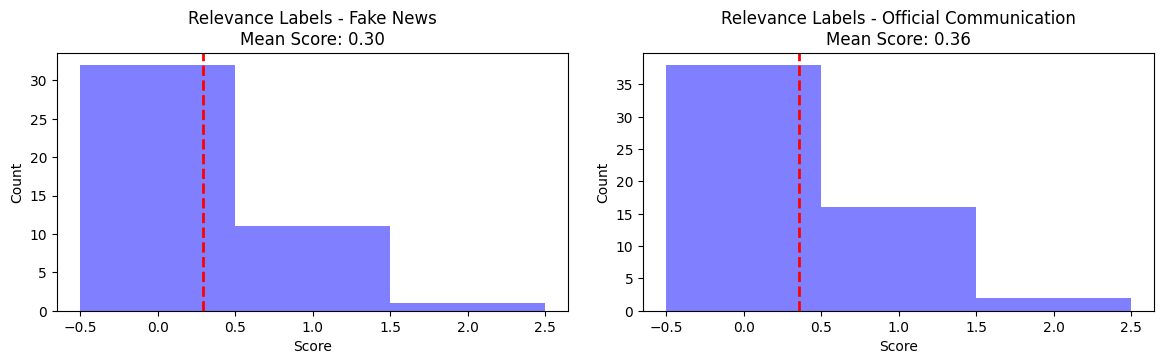

In [883]:
# Add labels 
com_labeling_short['label'] = sublist_labels_com.values

# Define your dataframe, name and color
df = com_labeling_short
name = "Relevance Labels"  # Replace with your actual dataframe name
color = 'blue'  # Replace with your desired color

fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # Adjust the figure size as needed

# Split the data into positive and negative classes
positive_df = df[df['label'] == 1]
negative_df = df[df['label'] == -1]

# Calculate mean scores
positive_mean = positive_df['score'].mean()
negative_mean = negative_df['score'].mean()

# Create histogram for positive class
axs[0].hist(positive_df['score'], bins=range(0, 4), align='left', color=color, alpha=0.5)
axs[0].set_title(f'{name} - Fake News\nMean Score: {positive_mean:.2f}')
axs[0].set_xlabel('Score')
axs[0].set_ylabel('Count')
axs[0].axvline(positive_mean, color='r', linestyle='dashed', linewidth=2)

# Create histogram for negative class
axs[1].hist(negative_df['score'], bins=range(0, 4), align='left', color=color, alpha=0.5)
axs[1].set_title(f'{name} - Official Communication\nMean Score: {negative_mean:.2f}')
axs[1].set_xlabel('Score')
axs[1].set_ylabel('Count')
axs[1].axvline(negative_mean, color='r', linestyle='dashed', linewidth=2)

# Adding some space between subplots
plt.tight_layout(pad=2.0)

# Displaying the plot
plt.show()



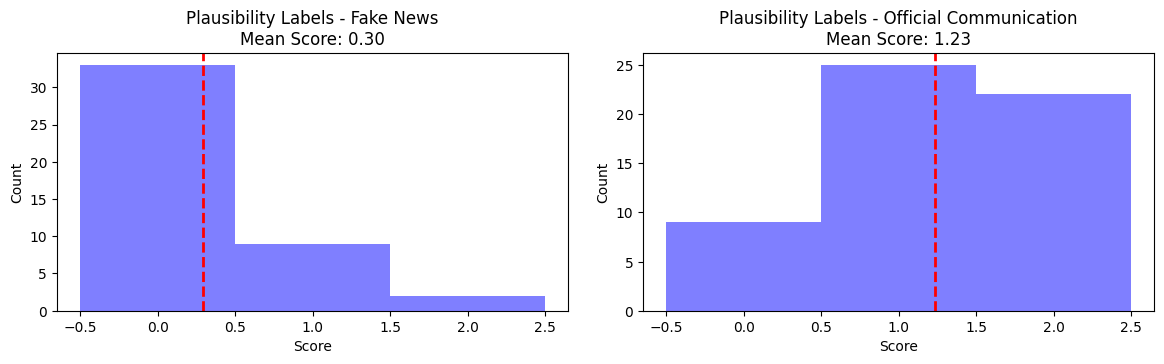

In [884]:
# Add labels 
plausibility_labeling_short['label'] = sublist_labels_com.values

# Define your dataframe, name and color
df = plausibility_labeling_short
name = "Plausibility Labels"  # Replace with your actual dataframe name
color = 'blue'  # Replace with your desired color

fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # Adjust the figure size as needed

# Split the data into positive and negative classes
positive_df = df[df['label'] == 1]
negative_df = df[df['label'] == -1]

# Calculate mean scores
positive_mean = positive_df['score'].mean()
negative_mean = negative_df['score'].mean()

# Create histogram for positive class
axs[0].hist(positive_df['score'], bins=range(0, 4), align='left', color=color, alpha=0.5)
axs[0].set_title(f'{name} - Fake News\nMean Score: {positive_mean:.2f}')
axs[0].set_xlabel('Score')
axs[0].set_ylabel('Count')
axs[0].axvline(positive_mean, color='r', linestyle='dashed', linewidth=2)

# Create histogram for negative class
axs[1].hist(negative_df['score'], bins=range(0, 4), align='left', color=color, alpha=0.5)
axs[1].set_title(f'{name} - Official Communication\nMean Score: {negative_mean:.2f}')
axs[1].set_xlabel('Score')
axs[1].set_ylabel('Count')
axs[1].axvline(negative_mean, color='r', linestyle='dashed', linewidth=2)

# Adding some space between subplots
plt.tight_layout(pad=2.0)

# Displaying the plot
plt.show()



In [865]:
plausibility_labeling_short

,tweet,score,label
0,The Access to COVID19 Tools (ACTConfusion Acce...,0,-1
1,"April 22, 2020\nThe Rockefeller Foundation has...",1,1
2,You still need to follow the rules after you’v...,1,-1
3,European companies have shown extraordinary so...,2,-1
4,You must self-isolate for 10 days if you:\n\n▶...,1,-1
...,...,...,...
95,Coronavirus update: How to access your GP this...,2,-1
96,"RT : If you have any coronavirus symptoms, you...",0,-1
97,This is untrue. \n\nAll students are required...,2,-1
98,"If you are feeling unwell🤒, you should avoid a...",2,-1


## Backup Experiments

In [345]:
import time
import numpy as np

def generate_novelty_rationale(sublist):
    # Define data
    results = {
        'tweet': [],
        'score': [],
        'rationale': []
    }

    # API call for every tweet
    for tweet in sublist: 
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {OPENAI_API_KEY}"
        }

        content = system_prompt + "Given this tweet: " + tweet + key_elements + task_description_rationale

        data = {
            "model": "gpt-3.5-turbo",
            "messages": [{"role": "user", "content": f"{content}"}],
            "max_tokens": 512,
            "temperature": 0.7
        }

        success = False
        for attempt in range(3):  # Retry up to 3 times
            try: 
                response = requests.post('https://api.openai.com/v1/chat/completions', 
                                         headers=headers, 
                                         data=json.dumps(data),
                                         timeout=30)  # Setting a timeout
                answer = response.json()['choices'][0]['message']['content']
                print(response.json())
                success = True  # If successful, break out of the retry loop
                break
            except requests.exceptions.Timeout:
                print("The request timed out.")
                time.sleep(1)  # Wait for 1 second before retrying
            except json.JSONDecodeError:
                print("Couldn't decode the response as JSON")
                time.sleep(1)  # Wait for 1 second before retrying
            except KeyError:
                print("There was an error with the API call.")
                print("Full response:")
                print(response.json())
                time.sleep(1)  # Wait for 1 second before retrying

        results["tweet"].append(tweet)
        if success:
            results["score"].append(answer.split(":")[1].split("\n")[0].strip())
            results["rationale"].append(answer)
        else:
            print(f"Failed to retrieve rationale for tweet {tweet} after 3 attempts.")
            results["score"].append(np.nan)  # Append NaN if all attempts failed
            results["rationale"].append(np.nan)  # Append NaN if all attempts failed
        
    return pd.DataFrame(results)


In [346]:
def generate_novelty_score(sublist):
    # Define data
    results_scores = {
        'tweet': [],
        'score': []
    }

    # API call for every tweet
    for tweet in sublist: 
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {OPENAI_API_KEY}"
        }

        content = system_prompt + "Given this tweet: " + tweet + key_elements + task_description_score

        data = {
            "model": "gpt-3.5-turbo",
            "messages": [{"role": "user", "content": f"{content}"}],
            "max_tokens": 512,
            "temperature": 0.7
        }
        
        success = False
        for attempt in range(3):  # Retry up to 3 times
            try: 
                response = requests.post('https://api.openai.com/v1/chat/completions', headers=headers, data=json.dumps(data))
                answer = response.json()['choices'][0]['message']['content']
                print(response.json())
                success = True  # If successful, break out of the retry loop
                break
            except json.JSONDecodeError:
                print("Couldn't decode the response as JSON")
                time.sleep(1)  # Wait for 1 second before retrying
            except KeyError:
                print("There was an error with the API call.")
                print("Full response:")
                print(response.json())
                time.sleep(1)  # Wait for 1 second before retrying

        results_scores["tweet"].append(tweet)
        if success:
            if answer.isdigit():
                results_scores["score"].append(answer)
            else: 
                # If not, split the string and convert to integer
                answer = re.findall(r'\d', answer)
                if answer:
                    results_scores["score"].append(answer[0])
                else:
                    results_scores["score"].append(np.nan)
        else:
            print(f"Failed to retrieve score for tweet {tweet} after 3 attempts.")
            results_scores["score"].append(np.nan)  # Append NaN if all attempts failed
        
    return pd.DataFrame(results_scores)


In [347]:
import time

def generate_novelty_label(sublist):
    # Define data
    results_scores = {
        'tweet': [],
        'score': []
    }

    # API call for every tweet
    for tweet in sublist: 
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {OPENAI_API_KEY}"
        }

        content = system_prompt + "Given this tweet: " + tweet + key_elements + task_description_label

        data = {
            "model": "gpt-3.5-turbo",
            "messages": [{"role": "user", "content": f"{content}"}],
            "max_tokens": 512,
            "temperature": 0.7
        }

        success = False
        for attempt in range(3):  # Retry up to 3 times
            try: 
                response = requests.post('https://api.openai.com/v1/chat/completions', 
                                        headers=headers, 
                                        data=json.dumps(data),
                                        timeout=30)
                answer = response.json()['choices'][0]['message']['content']
                print(response.json())
                success = True  # If successful, break out of the retry loop
                break  
            except requests.exceptions.Timeout:
                print("The request timed out.")
                time.sleep(1)
            except json.JSONDecodeError:
                print("Couldn't decode the response as JSON")
                time.sleep(1)  # Wait for 1 second before retrying
            except KeyError:
                print("There was an error with the API call.")
                print("Full response:")
                print(response.json())
                time.sleep(1)  # Wait for 1 second before retrying

        if success:
            results_scores["tweet"].append(tweet)
            results_scores["score"].append(answer)
        else:
            print(f"Failed to retrieve score for tweet {tweet} after 3 attempts.")
            results_scores["tweet"].append(tweet)
            results_scores["score"].append(np.nan)  # Append NaN if all attempts failed

    return pd.DataFrame(results_scores)


In [348]:
import time

def generate_novelty_no_key_elements(sublist):
    # Define data
    results_scores = {
        'tweet': [],
        'score': []
    }

    # API call for every tweet
    for tweet in sublist: 
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {OPENAI_API_KEY}"
        }

        content = system_prompt + "Given this tweet: " + tweet + task_description_no_key_elements

        data = {
            "model": "gpt-3.5-turbo",
            "messages": [{"role": "user", "content": f"{content}"}],
            "max_tokens": 512,
            "temperature": 0.7
        }

        success = False
        for attempt in range(3):  # Retry up to 3 times
            try: 
                response = requests.post('https://api.openai.com/v1/chat/completions', 
                                        headers=headers, 
                                        data=json.dumps(data),
                                        timeout=30)
                answer = response.json()['choices'][0]['message']['content']
                print(response.json())
                success = True  # If successful, break out of the retry loop
                break  
            except requests.exceptions.Timeout:
                print("The request timed out.")
                time.sleep(1)
            except json.JSONDecodeError:
                print("Couldn't decode the response as JSON")
                time.sleep(1)  # Wait for 1 second before retrying
            except KeyError:
                print("There was an error with the API call.")
                print("Full response:")
                print(response.json())
                time.sleep(1)  # Wait for 1 second before retrying

        if success:
            results_scores["tweet"].append(tweet)
            results_scores["score"].append(answer)
        else:
            print(f"Failed to retrieve score for tweet {tweet} after 3 attempts.")
            results_scores["tweet"].append(tweet)
            results_scores["score"].append(np.nan)  # Append NaN if all attempts failed

    return pd.DataFrame(results_scores)


#### Prompt Testing

In [359]:
sublist = feature_df[0:201]['preprocessed']
sublist_labels = feature_df[0:201]['label']
sublist

0      The drive-through coronavirus testing site in ...
1      "4⃣  and WHO are exploring how the EIB could s...
2                       Media briefing on COVID19 with  
3      RT : The new NHSCOVID19app, now available in E...
4                 Dr. Yan presented evidence Covid 19...
                             ...                        
196      Yes, I do. I don't think NPR, CNN, & other n...
197    "The whole-of-government approach reflected in...
198    "Our modelling suggests that a 50% drop in tub...
199      Less that 40 per 100,000 142 new cases in Wa...
200       Newsflash Idiots:\nMichigan and New York wi...
Name: preprocessed, Length: 201, dtype: object

In [360]:
results_novelty_rational = generate_novelty_rationale(sublist)
results_novelty_rational

{'id': 'chatcmpl-7VehB2Vhmqwjd21Xs1Eqgt4jzN3Hf', 'object': 'chat.completion', 'created': 1687778957, 'model': 'gpt-3.5-turbo-0301', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Score: 2\n\nReasoning: The tweet provides information about the opening of a drive-through coronavirus testing site in Leicester for those who have booked online. While this information is important, it is not particularly novel as testing sites have been opening up around the world for some time now. The tweet does not shake up my usual way of thinking nor does it contain any unique phrasing. Therefore, the tweet scores a 2 on the novelty check.'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 224, 'completion_tokens': 90, 'total_tokens': 314}}
{'id': 'chatcmpl-7VehEJnLmMGdYDSPKtz7GP8Q2OsHz', 'object': 'chat.completion', 'created': 1687778960, 'model': 'gpt-3.5-turbo-0301', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Score: 3\n\nReasoning: While the twe

,tweet,score,rationale
0,The drive-through coronavirus testing site in ...,2,Score: 2\n\nReasoning: The tweet provides info...
1,"""4⃣ and WHO are exploring how the EIB could s...",3,Score: 3\n\nReasoning: While the tweet present...
2,Media briefing on COVID19 with,2,Score: 2\n\nReasoning: The tweet does not pres...
3,"RT : The new NHSCOVID19app, now available in E...",2,Score: 2\n\nReasoning: The tweet presents info...
4,Dr. Yan presented evidence Covid 19...,1,Score: 1\n\nReasoning: This tweet is not novel...
...,...,...,...
196,"Yes, I do. I don't think NPR, CNN, & other n...",3,Novelty Score: 3\n\nReasoning: The tweet prese...
197,"""The whole-of-government approach reflected in...",2,Score: 2\n\nReasoning: \n1) Novelty Check: The...
198,"""Our modelling suggests that a 50% drop in tub...",3,Score: 3\n\nReasoning: While the tweet contain...
199,"Less that 40 per 100,000 142 new cases in Wa...",2,Score: 2\n\nReasoning: While the tweet present...


In [361]:
results_novelty_score = generate_novelty_score(sublist)
results_novelty_score

{'id': 'chatcmpl-7VfCcwJkM9tmnhWyNuYvWE1uUlNzR', 'object': 'chat.completion', 'created': 1687780906, 'model': 'gpt-3.5-turbo-0301', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Score: 3'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 247, 'completion_tokens': 4, 'total_tokens': 251}}
{'id': 'chatcmpl-7VfCdN48tCaUKCDRgbS09gSYYJpgV', 'object': 'chat.completion', 'created': 1687780907, 'model': 'gpt-3.5-turbo-0301', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '3'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 258, 'completion_tokens': 1, 'total_tokens': 259}}
{'id': 'chatcmpl-7VfCfR9LcRUjl9U0hUuYXu4SAsBIJ', 'object': 'chat.completion', 'created': 1687780909, 'model': 'gpt-3.5-turbo-0301', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '3'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 221, 'completion_tokens': 1, 'total_tokens': 222}}
{'id': 'chatcmpl-7VfCf8Ot6We1aWLoIBLHDiPm1hGEW', 'object'

,tweet,score
0,The drive-through coronavirus testing site in ...,3
1,"""4⃣ and WHO are exploring how the EIB could s...",3
2,Media briefing on COVID19 with,3
3,"RT : The new NHSCOVID19app, now available in E...",2
4,Dr. Yan presented evidence Covid 19...,3
...,...,...
196,"Yes, I do. I don't think NPR, CNN, & other n...",3
197,"""The whole-of-government approach reflected in...",2
198,"""Our modelling suggests that a 50% drop in tub...",3
199,"Less that 40 per 100,000 142 new cases in Wa...",2


In [362]:
results_novelty_label = generate_novelty_label(sublist)

# Define mapping dictionary
label_mapping = {
    "Very novel.": 5,
    "Very novel": 5,
    "novel.": 4,
    "novel": 4,
    "Moderately novel.": 3,
    "Moderately novel": 3,
    "Slightly novel.": 2,
    "Slightly novel": 2,
    "Not novel at all.": 1,
    "Not novel at all": 1
}

# Suppose df is your DataFrame and 'labels' is the column that contains the labels

results_novelty_label['score'] = results_novelty_label['score'].map(label_mapping)
results_novelty_label


{'id': 'chatcmpl-7VfPeEfpVklJusCgYA6itRTF0aNBz', 'object': 'chat.completion', 'created': 1687781714, 'model': 'gpt-3.5-turbo-0301', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Moderately novel.'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 238, 'completion_tokens': 4, 'total_tokens': 242}}
{'id': 'chatcmpl-7VfPewVA9fxfS1MmdwA9ugGRf6gj9', 'object': 'chat.completion', 'created': 1687781714, 'model': 'gpt-3.5-turbo-0301', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Moderately novel.'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 249, 'completion_tokens': 4, 'total_tokens': 253}}
{'id': 'chatcmpl-7VfPfHVf4jbuZMZ9PmXIbUemiWg7d', 'object': 'chat.completion', 'created': 1687781715, 'model': 'gpt-3.5-turbo-0301', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Moderately novel.'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 212, 'completion_tokens': 4, 'total_tokens': 216}}
{'id': 'chatcmpl

,tweet,score
0,The drive-through coronavirus testing site in ...,3.0
1,"""4⃣ and WHO are exploring how the EIB could s...",3.0
2,Media briefing on COVID19 with,3.0
3,"RT : The new NHSCOVID19app, now available in E...",3.0
4,Dr. Yan presented evidence Covid 19...,3.0
...,...,...
196,"Yes, I do. I don't think NPR, CNN, & other n...",3.0
197,"""The whole-of-government approach reflected in...",2.0
198,"""Our modelling suggests that a 50% drop in tub...",3.0
199,"Less that 40 per 100,000 142 new cases in Wa...",3.0


In [363]:
results_novelty_label = results_novelty_label.fillna(0)
results_novelty_label

,tweet,score
0,The drive-through coronavirus testing site in ...,3.0
1,"""4⃣ and WHO are exploring how the EIB could s...",3.0
2,Media briefing on COVID19 with,3.0
3,"RT : The new NHSCOVID19app, now available in E...",3.0
4,Dr. Yan presented evidence Covid 19...,3.0
...,...,...
196,"Yes, I do. I don't think NPR, CNN, & other n...",3.0
197,"""The whole-of-government approach reflected in...",2.0
198,"""Our modelling suggests that a 50% drop in tub...",3.0
199,"Less that 40 per 100,000 142 new cases in Wa...",3.0


In [364]:
results_novelty_no_key_elements = generate_novelty_no_key_elements(sublist)

# Define mapping dictionary
label_mapping = {
    "Very novel.": 5,
    "Very novel": 5,
    "novel.": 4,
    "novel": 4,
    "Moderately novel.": 3,
    "Moderately novel": 3,
    "Slightly novel.": 2,
    "Slightly novel": 2,
    "Not novel at all.": 1,
    "Not novel at all": 1
}

# Suppose df is your DataFrame and 'labels' is the column that contains the labels
results_novelty_no_key_elements['score'] = results_novelty_no_key_elements['score'].map(label_mapping)
results_novelty_no_key_elements

{'id': 'chatcmpl-7VfWZwCaOl1KxQTKm3A1Z6ixwxPF9', 'object': 'chat.completion', 'created': 1687782143, 'model': 'gpt-3.5-turbo-0301', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Moderately novel.'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 155, 'completion_tokens': 4, 'total_tokens': 159}}
{'id': 'chatcmpl-7VfWe7hgVJ0EYZS8j5AEmKOrWzbsO', 'object': 'chat.completion', 'created': 1687782148, 'model': 'gpt-3.5-turbo-0301', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Moderately novel'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 166, 'completion_tokens': 3, 'total_tokens': 169}}
{'id': 'chatcmpl-7VfWeCjDdr0z2Cii4xeA77Ks5bWNz', 'object': 'chat.completion', 'created': 1687782148, 'model': 'gpt-3.5-turbo-0301', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Slightly novel.'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 129, 'completion_tokens': 4, 'total_tokens': 133}}
{'id': 'chatcmpl-7V

,tweet,score
0,The drive-through coronavirus testing site in ...,3.0
1,"""4⃣ and WHO are exploring how the EIB could s...",3.0
2,Media briefing on COVID19 with,2.0
3,"RT : The new NHSCOVID19app, now available in E...",2.0
4,Dr. Yan presented evidence Covid 19...,2.0
...,...,...
196,"Yes, I do. I don't think NPR, CNN, & other n...",2.0
197,"""The whole-of-government approach reflected in...",2.0
198,"""Our modelling suggests that a 50% drop in tub...",NaN
199,"Less that 40 per 100,000 142 new cases in Wa...",2.0


In [365]:
for index, row in results_novelty_rational.iterrows():
    print(row['rationale'])

Score: 2

Reasoning: The tweet provides information about the opening of a drive-through coronavirus testing site in Leicester for those who have booked online. While this information is important, it is not particularly novel as testing sites have been opening up around the world for some time now. The tweet does not shake up my usual way of thinking nor does it contain any unique phrasing. Therefore, the tweet scores a 2 on the novelty check.
Score: 3

Reasoning: While the tweet presents new information about the collaboration between the EIB and WHO to support the COVID-19 supply chain system, it is not entirely unexpected given the current global situation. The tweet is not particularly complex or ambiguous, and the language used is straightforward and descriptive. However, the mention of "other medical supplies" beyond personal protective equipment and diagnostics could be considered a slightly unexpected addition. Overall, the tweet is somewhat novel but not groundbreaking.
Score

In [366]:
# Convert 'score' columns to float
results_novelty_rational['score'] = pd.to_numeric(results_novelty_rational['score'], errors='coerce')
results_novelty_label['score'] = pd.to_numeric(results_novelty_label['score'], errors='coerce')
results_novelty_score['score'] = pd.to_numeric(results_novelty_score['score'], errors='coerce')

# Compute the absolute differences
diff_label = abs(results_novelty_rational['score'] - results_novelty_label['score'])
diff_score = abs(results_novelty_rational['score'] - results_novelty_score['score'])

# Compute the average differences
avg_diff_label = diff_label.mean()
avg_diff_score = diff_score.mean()

# Compute the average differences
avg_diff_label = diff_label.mean()
avg_diff_score = diff_score.mean()

print(avg_diff_label)
print(avg_diff_score)


0.5870646766169154
0.7014925373134329


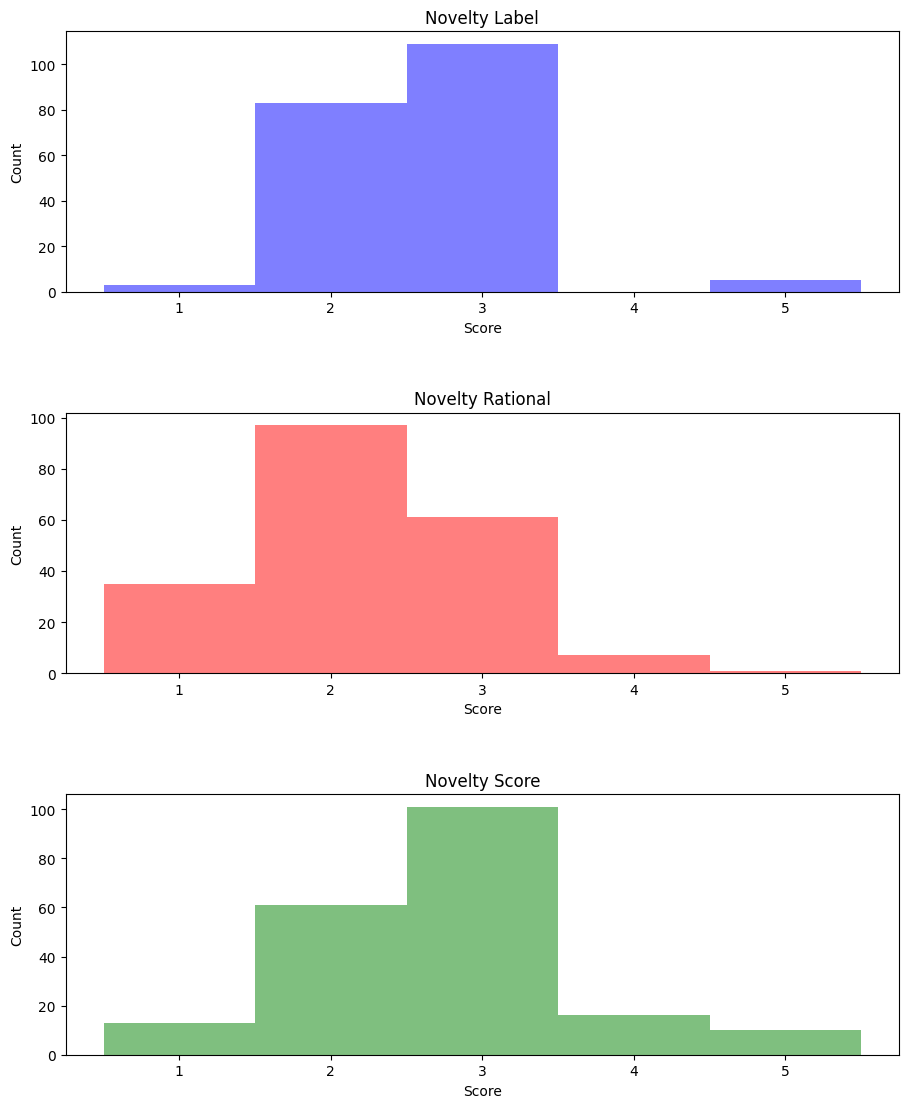

In [367]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(10,12))

# Creating histogram for results_novelty_label
axs[0].hist(results_novelty_label['score'], bins = range(1,7), align='left', color='blue', alpha=0.5)
axs[0].set_title('Novelty Label')
axs[0].set_xlabel('Score')
axs[0].set_ylabel('Count')

# Creating histogram for results_novelty_rational
axs[1].hist(results_novelty_rational['score'], bins = range(1,7), align='left', color='red', alpha=0.5)
axs[1].set_title('Novelty Rational')
axs[1].set_xlabel('Score')
axs[1].set_ylabel('Count')

# Creating histogram for results_novelty_score
axs[2].hist(results_novelty_score['score'], bins = range(1,7), align='left', color='green', alpha=0.5)
axs[2].set_title('Novelty Score')
axs[2].set_xlabel('Score')
axs[2].set_ylabel('Count')

# Adding some space between subplots
plt.tight_layout(pad=4.0)

# Displaying the plot
plt.show()


In [368]:
# Define the names of the DataFrames and labels for plotting
dataframes = [results_novelty_label, results_novelty_rational, results_novelty_score, results_novelty_no_key_elements]
names = ["Novelty Label", "Novelty Rational", "Novelty Score", "Novelty No Key Elements"]
colors = ["blue", "red", "green", "purple"]

# Add labels to each DataFrame
for df in dataframes:
    df['label'] = sublist_labels.values


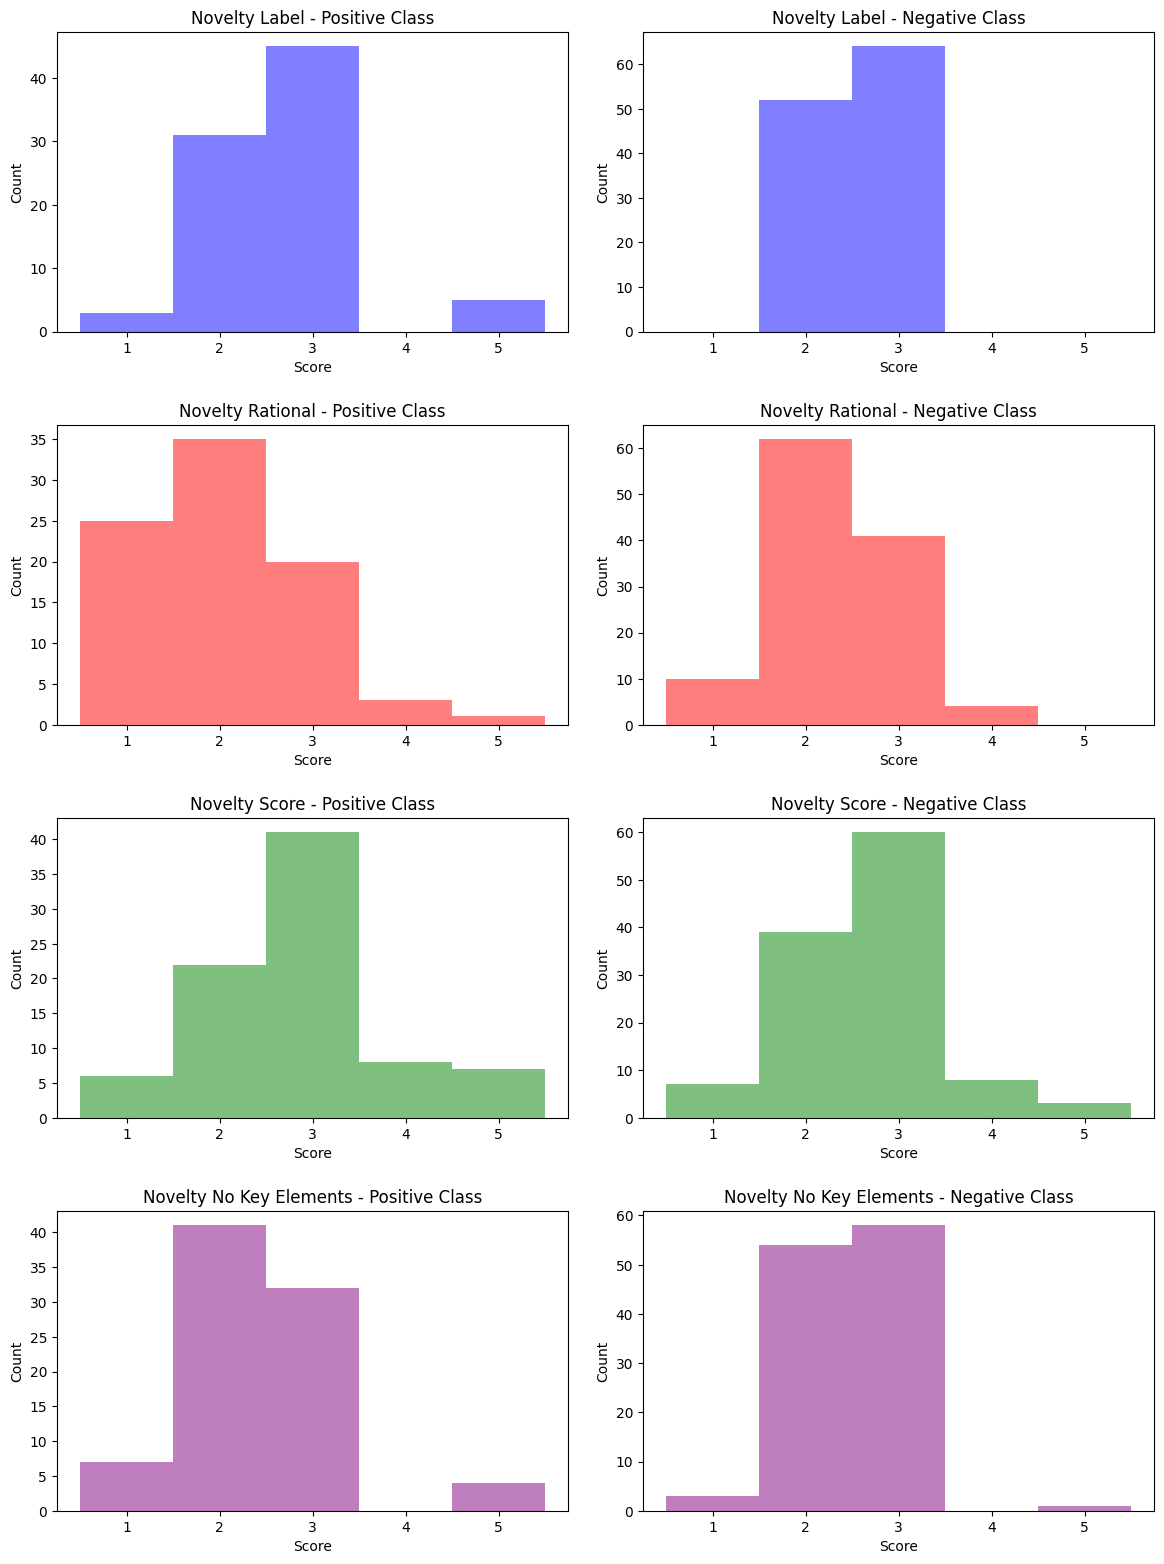

In [369]:
import matplotlib.pyplot as plt

# Calculate the number of rows needed for the subplots
n_rows = len(dataframes)
n_cols = 2  # We want 2 columns of subplots

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 4*n_rows))  # Adjust the figure size as needed

for i, (df, name, color) in enumerate(zip(dataframes, names, colors)):
    # Split the data into positive and negative classes
    positive_df = df[df['label'] == 1]
    negative_df = df[df['label'] == -1]

    # Create histogram for positive class
    axs[i, 0].hist(positive_df['score'], bins=range(1, 7), align='left', color=color, alpha=0.5)
    axs[i, 0].set_title(f'{name} - Positive Class')
    axs[i, 0].set_xlabel('Score')
    axs[i, 0].set_ylabel('Count')

    # Create histogram for negative class
    axs[i, 1].hist(negative_df['score'], bins=range(1, 7), align='left', color=color, alpha=0.5)
    axs[i, 1].set_title(f'{name} - Negative Class')
    axs[i, 1].set_xlabel('Score')
    axs[i, 1].set_ylabel('Count')

# Adding some space between subplots
plt.tight_layout(pad=2.0)

# Displaying the plot
plt.show()


#### Encoding

In [ ]:
labels = "Very novel, novel, Moderately novel, Slightly novel, Not novel at all"

key_elements = """And given these key elements:
1) Novelty Check: Is the tweet presenting new, sudden, unfamiliar or unexpected information or perspectives?
2) Complexity Check: Does the tweet shake up your usual way of thinking? Is it complex, obscure, or ambiguous? Does it have an air of uncertainty or contains contradictions that make you pause and ponder?
3) Unique Phrasing: Does the tweet use innovative or unique language, metaphors, analogies or irony?"""

task_description_rationale = """Carefully read the text of the tweet, paying close attention to details. Provide an novelty score for the tweet based on above key elements.
The score should be between 1 and 5, where 1 indicates not novel and 5 very novel. 
Before you answer, think step by step. Please first provide the score first, then give a brief reasoning. """

task_description_score = """Carefully read the text of the tweet, paying close attention to details. Provide an novelty score for the tweet based on above key elements.
The score should be between 1 and 5, where 1 indicates not novel and 5 very novel. 
Before you answer, think step by step. Act as if you would provide a reasoning for your answer but do not include it in the output. 
Your final answer should only be the score (integer without any further text) """

task_description_label = f"""Your job is to correctly label the provided input example into one of the following categories: {labels} 
Carefully read the text of the tweet, paying close attention to details. Then, assign the tweet label based on an evaluation of above key elements.
Before you answer, think step by step. You will just return one line consisting of the label for the given example."""

task_description_no_key_elements = f""" Your job is to correctly label the provided input example into one of the following categories: {labels} 
Carefully read the text of the tweet, paying close attention to details. Then, assign the tweet label based on whether the tweet contains novel or surprising information 
or makes a puzzling statement. Before you answer, think step by step. You will just return one line consisting of the label for the given example """
